### Imports & data Directory

In [1]:
import math
import os
import natsort
import skimage
import numpy as np
import pandas as pd
from natsort import natsorted, ns
from skimage import io, color
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib import markers
from matplotlib.lines import lineStyles
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC, l1_min_c
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import scipy.misc
from scipy import ndimage
import seaborn as sns
import warnings
from IPython.display import display, HTML

%matplotlib inline 

In [2]:
#Directory
data = 'HPTLCRaw\\'

### Grey Scale Import

##### Import Images as Grey Scale

In [3]:
list_files = os.listdir(data)
list_files = natsorted(list_files)
image_list = []
for filename in list_files:
    image_list.append(color.rgb2gray(io.imread(data+filename)[:,:,:3]))

##### Crop all Images

In [4]:
cropped_img_list = []
for image in image_list:
    cropped_img_list.append(image[70:1100,96:-84])

##### Plot Every Cropped File as a Greyscale Image

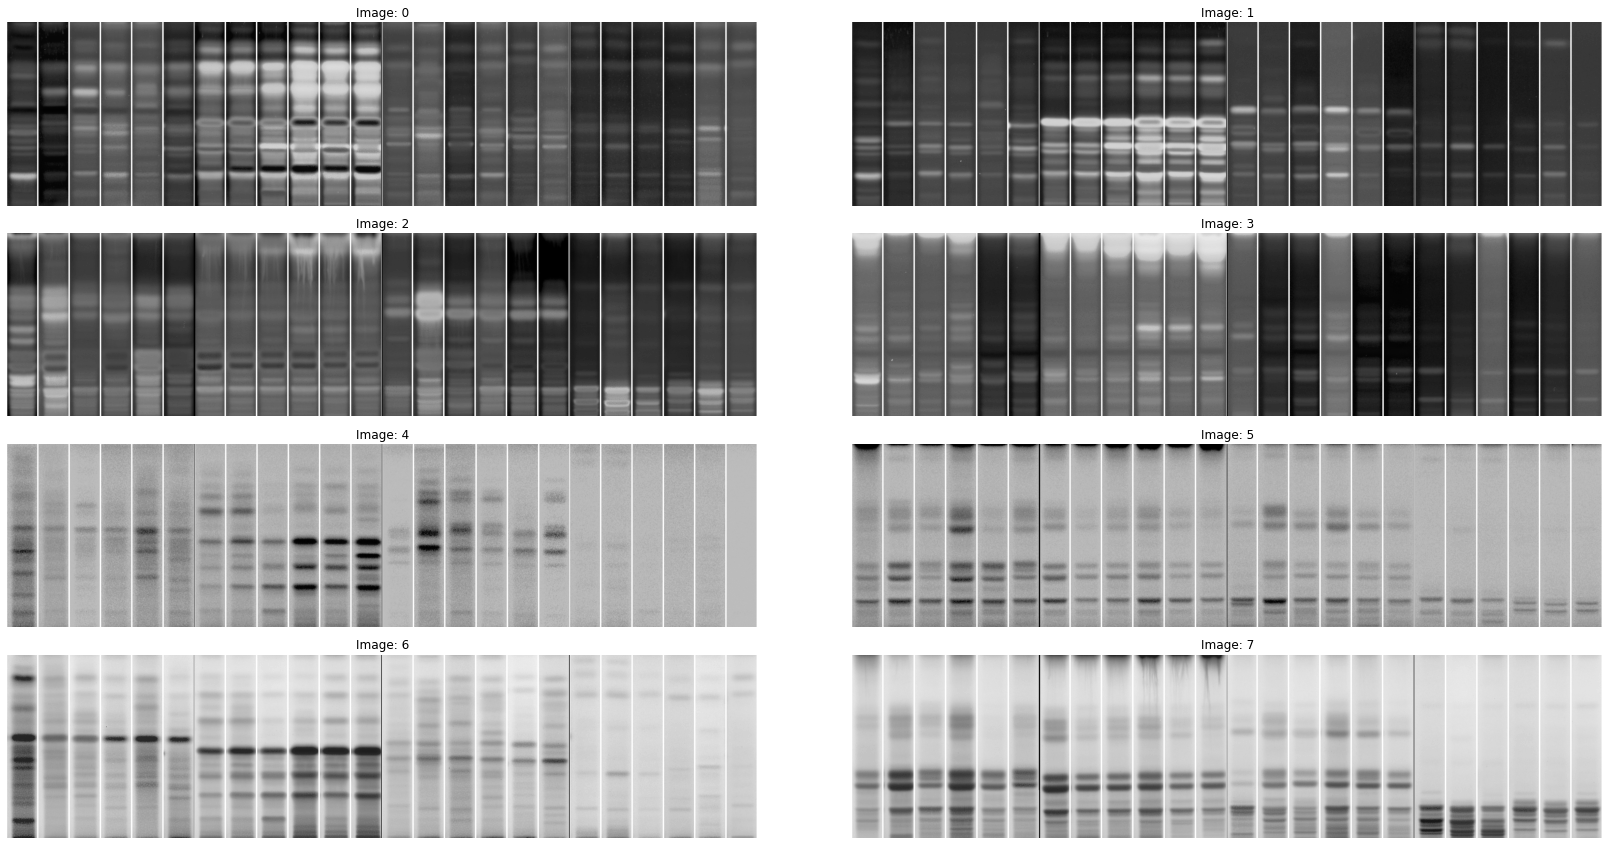

In [5]:
fig = plt.figure(figsize=(30, 15))
for i, img in enumerate(cropped_img_list):
    sub = fig.add_subplot(4, 2, i + 1)
    sub.axis('off')
    sub.imshow(img,cmap='gray')
    sub.set_title('Image: '+str(i))
plt.tight_layout
fig.subplots_adjust(wspace=.02, hspace=.15)

##### Verifying Shape of each Cropped Image


In [6]:
for i in range(len(cropped_img_list)):
    print(np.shape(cropped_img_list[i]))

(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)


### Algorithm to determine crop locations

In [7]:
def det_crop_locations(ar):
    maxVal = ar.max()
    res = []
    res.append([0,0])
    n = len(ar)

    i = 10
    while i < len(ar-5):
        # While we are within bounds and
        # we have not found a peak or
        # haven't yet travelled at least 100 pixels or
        # are not within 5% of the max value
        # increment i
        while (i < n-5) and (not (ar[i] >= ar[i-1] and ar[i] >= ar[i+1]) or not (i - res[-1][0] > 100) or not(ar[i] > (.85*maxVal))):
            i += 1

        #if we reach the end of the image, break the loop
        if i >= n-5:
            break

        # Add Back wall of single strip to q
        res[-1][1] = i - 15
        
        #Add front wall to q
        res.append([i + 15,0])
        
    #remove last appended crop as it is at the end of the image and therefore not useful
    res.pop()
    return res

#### Use Function to Determine Crop Locations of Each Image

In [8]:
crops_list = []
for cropped_img in cropped_img_list:
    temp = pd.DataFrame(cropped_img)
    temp_hi_cnt = temp[temp>.8].count()
    temp_low_cnt = temp[temp==0].count()
    temp_cnt = temp_hi_cnt + temp_low_cnt
    crops_list.append(det_crop_locations(temp_cnt.copy()))

In [9]:
# Verify Number of Crops for Each Image
for crops in crops_list:
    print(len(crops))

24
24
24
24
24
24
24
24


##### Generate Plot of Crop Locations for all Images -> Common Sense Check Reasonability of Algorithm Results

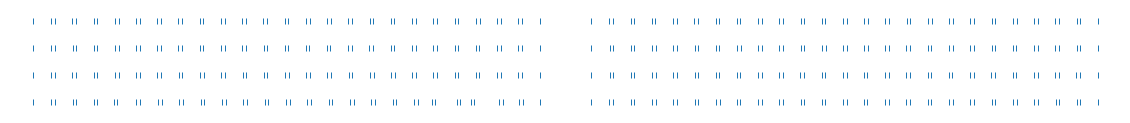

In [10]:
fig = plt.figure(figsize=(20, 2))
for i, crops in enumerate(crops_list):
    temp = pd.DataFrame(crops).to_numpy().flatten()
    sub = fig.add_subplot(4,2,i+1)
    sub.axis('off')
    sub.plot(temp,np.zeros_like(temp),'|')
plt.tight_layout
fig.subplots_adjust(wspace=.001, hspace=0)

##### Cropping Images and adding Individual Slices to new Array

In [11]:
multiview_strip_array = []

#For every View
for i, cropped_image in enumerate(cropped_img_list):
    min_width = float('inf')
    strip_array = []

    #First find the minimum width of all the crops
    for crop in crops_list[i]:
        front, back = crop
        min_width = min(min_width,back-front)

    #Get half of that min width
    min_width_half = int((min_width-2)/2)

    #For each of the crops, crop them from their own midpoint +- the mind_width_half value
    for crop in crops_list[i]:
        front, back = crop
        strip_mid = int(back/2 + front/2)
        min_front = strip_mid - min_width_half
        min_back = min_width_half + strip_mid
        strip_array.append(cropped_image[:,min_front:min_back])

    multiview_strip_array.append(strip_array)

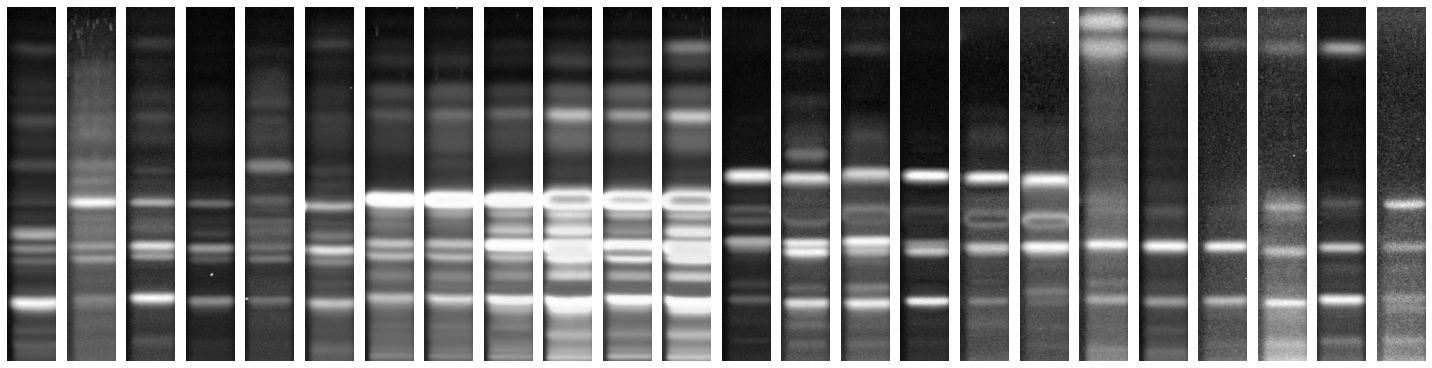

In [12]:
# Individual Print
# strip_array = strip_array_list[1]
strip_array = multiview_strip_array[1]
fig = plt.figure(figsize=(20, 10))
for i, strip in enumerate(strip_array):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    sub.imshow(strip,cmap='gray')
plt.tight_layout()

### Transforming each Strip in array to a 1D Vector by getting average value of each row

In [13]:
multiview_strip_row_avg_list = []

for strip_array in multiview_strip_array:
    strip_row_avg = []

    for i, strip in enumerate(strip_array):
        strip_row_avg.append([])
        for row in strip:
            strip_row_avg[i].append(row.mean())

    multiview_strip_row_avg_list.append(strip_row_avg)

In [14]:
np.shape(multiview_strip_row_avg_list[0][0])

(1030,)

In [15]:
np.shape(np.transpose([multiview_strip_row_avg_list[0][i] for k in range(min_width)]))

(1030, 140)

#### Plotting arrays of average values to verify mean of each row

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

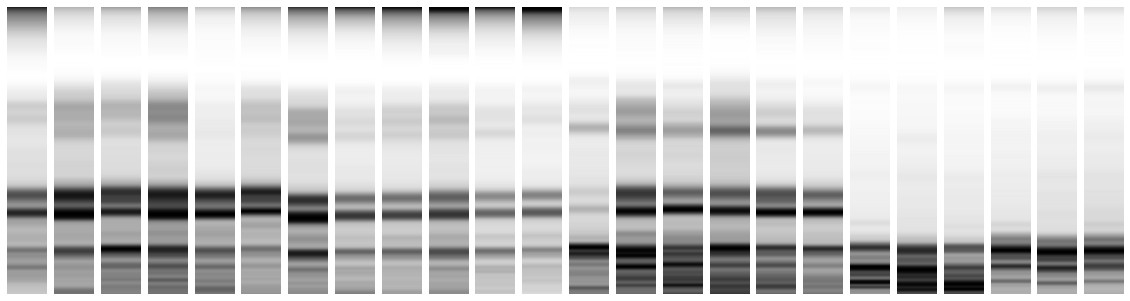

In [16]:
# Individual
fig = plt.figure(figsize=(20, 10)) 
for i in range(24):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    img = [multiview_strip_row_avg_list[-1][i] for k in range(min_width)]
    img = np.transpose(img)
    sub.imshow(img, cmap='gray')
plt.tight_layout

### Setting up Target Values & Dictionary Mapping

In [17]:
# 1 (GG): Rows 1 - 6 
# 2 (GI): Rows 7 - 12
# 3 (GU): Rows 13 - 18
# 4 (GE): Rows 19 - 21
# 5 (GL): Rows 22 - 24
map = {1:'GG',2:'GI',3:'GU',4:'GE',5:'GL'}
print(map[4])

GE


In [18]:
np.shape(multiview_strip_row_avg_list)

(8, 24, 1030)

In [19]:
np.shape(multiview_strip_row_avg_list[0])

(24, 1030)

In [20]:
#Done for the purposes of appending all views into 1 long feature vector later
no_targets_multiview_strip_row_avg_list = np.array(multiview_strip_row_avg_list).copy()

##### Append Targets to feature array

In [21]:
for strip_row_avg in multiview_strip_row_avg_list:
    for i in range(6):
        # strip_row_avg[i].append(1)
        strip_row_avg[i] = np.append(strip_row_avg[i],1)
    for i in range(6,12):
        # strip_row_avg[i].append(2)
        strip_row_avg[i] = np.append(strip_row_avg[i],2)
    for i in range(12,18):
        # strip_row_avg[i].append(3)
        strip_row_avg[i] = np.append(strip_row_avg[i],3)
    for i in range(18,21):
        # strip_row_avg[i].append(4)
        strip_row_avg[i] = np.append(strip_row_avg[i],4)
    for i in range(21,24):
        # strip_row_avg[i].append(5)
        strip_row_avg[i] = np.append(strip_row_avg[i],5)

In [22]:
#Verifying Shape of Multiview Multi-Dimensional Array
print(np.shape(multiview_strip_row_avg_list))

(8, 24, 1031)


In [23]:
# Verifying values are w/n the 0 - 1 range
print(np.shape(multiview_strip_row_avg_list[0][0]))
print(max(multiview_strip_row_avg_list[0][0]))
print(min(multiview_strip_row_avg_list[0][0]))

(1031,)
1.0
0.046075564761115705


## Selecting "Useful Features" across Each View and Training Models

### Model to Get Best Parameters per View

In [24]:
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,3,4,5,6,7,8]
best_params = []

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        tol=2e-3,
                        C=r_c)

        #Print Model Params
        # print("Model Params: "+str(model.get_params()))

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})

    #Get index of first 100% Accuracy row
    first_perfect_row_index = results[results.Accuracy==1.0].first_valid_index()

    #Get row at first_perfect_row_index
    first_perfect_row = pd.DataFrame(results.iloc[first_perfect_row_index])

    #Transpose to row format
    # first_perfect_row = first_perfect_row.transpose()

    #Change index name to match view number
    first_perfect_row = first_perfect_row.rename(columns={first_perfect_row_index:i})

    #Display and Append
    display(first_perfect_row)
    best_params.append(first_perfect_row)

View 1


,0
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,73.0


View 2


,1
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,65.0


View 3


,2
Accuracy,1.0
Regularizers,1.0
Unique Non-Zero Weight Count,30.0


View 4


,3
Accuracy,1.0
Regularizers,5.0
Unique Non-Zero Weight Count,94.0


View 5


,4
Accuracy,1.0
Regularizers,6.0
Unique Non-Zero Weight Count,112.0


View 6


,5
Accuracy,1.0
Regularizers,3.0
Unique Non-Zero Weight Count,61.0


View 7


,6
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,100.0


View 8


,7
Accuracy,1.0
Regularizers,3.0
Unique Non-Zero Weight Count,103.0


In [25]:
np_best_params = np.array(best_params)

In [26]:
best_regularizer_per_view = []
for i in range(len(np_best_params)):
    print("View "+str(i+1)+" Regularizer: "+str(np_best_params[i][1]))
    best_regularizer_per_view.append(np_best_params[i][1])

View 1 Regularizer: [4.]
View 2 Regularizer: [4.]
View 3 Regularizer: [1.]
View 4 Regularizer: [5.]
View 5 Regularizer: [6.]
View 6 Regularizer: [3.]
View 7 Regularizer: [4.]
View 8 Regularizer: [3.]


In [27]:
print(best_regularizer_per_view)

[array([4.]), array([4.]), array([1.]), array([5.]), array([6.]), array([3.]), array([4.]), array([3.])]


### Model to Get Unique Non-Zero Columns per View

In [28]:
all_accuracies = []
all_nonzero_weight_cnts = []
important_features_by_view = []
for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #l1, squared_hinge, dual = False
    model.set_params(random_state=101,
                    verbose=0,
                    max_iter=4500,
                    penalty='l1',
                    loss='squared_hinge',
                    dual=False,
                    tol=2e-3,
                    C=best_regularizer_per_view[i])

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    accuracy.append(round(model.score(df_feat,df_target),3))

    #Append Count of Number of Non-Zero Weights
    nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    # print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":best_regularizer_per_view[i],"Unique Non-Zero Weight Count":nonzero_weight_cnt})

    #####
    #Get Table of non-zero coefs in model's coef
    #   Row 1 holds the row index values in the full coef table
    #   Row 2 holds the column index values in the full coef table
    model_coefs_nonzero = pd.DataFrame(np.nonzero(model.coef_.copy()))

    #Get Array of Unique Columns with at least 1 non-zero value
    nonzero_cols = np.unique(model_coefs_nonzero.iloc[1])

    important_features_by_view.append(nonzero_cols)



In [29]:
#Number of Features at first occurence of 100% accuracy
for i in range(len(important_features_by_view)):
    print('View '+str(i+1)+': '+str(len(important_features_by_view[i])))
    # print(str(important_features_by_view[i]))

View 1: 73
View 2: 65
View 3: 30
View 4: 94
View 5: 112
View 6: 61
View 7: 100
View 8: 103


## Idea - Union of Overlapping Intervals

---
##### (Everything above this must be run. Below this, Attempts may be run individually AS LONG AS you Define the following function and combine all important features from each view)

In [30]:
# Function to Extract intervals from an array of values
# Expects list to be already sorted
# Strictness is how far apart values can be to be considered 'adjacent'
def interval_extract_loose(list, strictness):
    length = len(list)
    i = 0
    while (i< length):
        low = list[i]
        while i <length-1 and list[i]+strictness >= list[i + 1]: # the 2 can be variable
            i += 1
        high = list[i]
        if (high - low >= 1):
            yield [low, high]
        elif (high - low == 1):
            yield [low, ]
            yield [high, ]
        else:
            yield [low, ]
        i += 1

In [31]:
for i in range(len(important_features_by_view)):
    print(len(important_features_by_view[i]))
    print(type(important_features_by_view[i]))
    # print(np.shape(important_features_by_view[i]))

73
<class 'numpy.ndarray'>
65
<class 'numpy.ndarray'>
30
<class 'numpy.ndarray'>
94
<class 'numpy.ndarray'>
112
<class 'numpy.ndarray'>
61
<class 'numpy.ndarray'>
100
<class 'numpy.ndarray'>
103
<class 'numpy.ndarray'>


In [32]:
#Combine all our View's 'Important Features' and Sort
combined_important_features = np.concatenate(important_features_by_view)
combined_important_features = np.sort(combined_important_features)
print(len(combined_important_features))

638


If you want to suppress warnings:

In [33]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

### Attempt 1 - Union of Overlapping Intervals where Intervals are Determined Very Strictly (only consecutive values) ~ Proof of Concept ~ See other Attempts

In [34]:
# Function to Extract intervals from an array of values
def interval_extract(list):
    length = len(list)
    i = 0
    while (i< length):
        low = list[i]
        while i <length-1 and list[i]+1 == list[i + 1]:
            i += 1
        high = list[i]
        if (high - low >= 1):
            yield [low, high]
        elif (high - low == 1):
            yield [low, ]
            yield [high, ]
        else:
            yield [low, ]
        i += 1

In [35]:
# Get intervals from a single view TEST
temp = list(interval_extract(important_features_by_view[0]))
print(temp)

[[0, 2], [4, 6], [8], [11, 12], [15], [108, 109], [145, 146], [232, 239], [254, 264], [385, 386], [389, 390], [392, 401], [492, 498], [629], [636, 639], [688], [691, 694], [815, 816], [827, 828], [837], [864], [871], [960, 961]]


In [36]:
#Get intervals for every every view and append to array
intervals_in_view = []
for ar in important_features_by_view:
    temp = list(interval_extract(ar))
    intervals_in_view.append(temp)
print(intervals_in_view)

[[[0, 2], [4, 6], [8], [11, 12], [15], [108, 109], [145, 146], [232, 239], [254, 264], [385, 386], [389, 390], [392, 401], [492, 498], [629], [636, 639], [688], [691, 694], [815, 816], [827, 828], [837], [864], [871], [960, 961]], [[41], [116], [118, 122], [235], [241, 243], [458, 459], [461, 462], [487, 490], [493, 498], [503], [541], [543, 549], [567, 574], [659, 663], [683, 684], [688, 689], [693], [734, 735], [846], [864, 865], [868], [967], [969, 971], [1020, 1022]], [[29, 30], [101, 111], [386, 387], [389], [446, 448], [458, 460], [810], [813, 814], [850], [872], [889, 890], [966]], [[17], [20, 21], [23, 24], [26, 32], [34], [37, 38], [74], [76, 91], [147, 150], [156], [379], [585, 592], [596, 597], [664, 665], [684, 688], [773, 775], [777], [822, 824], [826, 828], [830, 834], [837], [840, 845], [848], [887, 889], [934, 939], [941, 942], [945, 948], [1016]], [[3, 4], [31, 32], [42, 44], [52, 54], [72, 74], [82], [87], [276, 281], [381, 383], [390, 392], [455], [478, 499], [512, 5

In [37]:
#Create one long list of intervals
combined_intervals = np.concatenate(intervals_in_view)

print(np.shape(combined_intervals))
print(type(combined_intervals))
combined_intervals = combined_intervals.tolist()

(165,)
<class 'numpy.ndarray'>


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [38]:
#If interval in foramt of a single value, set to format of [a, a]
for item in combined_intervals:
    if len(item) == 1:
        item.append(item[0])

In [39]:
#Function to merge all intervals
def merge(intervals):
        intervals.sort(key = lambda x: x[0])
        
        combined = []
        
        for interval in intervals:
            if not combined or combined[-1][1] < interval[0]:
                combined.append(interval)
            else:
                combined[-1][1] = max(combined[-1][1], interval[1])
        
        return combined

In [40]:
#Merge all intervals
merged_intervals = merge(combined_intervals)
print(merged_intervals)
print(len(merged_intervals))

[[0, 10], [11, 12], [13, 15], [17, 17], [19, 19], [20, 21], [23, 24], [26, 32], [34, 34], [37, 46], [52, 54], [72, 74], [76, 91], [101, 111], [116, 116], [118, 122], [127, 132], [145, 146], [147, 150], [156, 156], [208, 211], [217, 217], [232, 239], [241, 243], [247, 249], [253, 264], [276, 281], [379, 379], [381, 383], [385, 387], [389, 401], [438, 451], [455, 455], [458, 503], [512, 515], [534, 556], [559, 564], [567, 574], [585, 597], [598, 600], [604, 609], [627, 630], [636, 639], [651, 665], [668, 679], [683, 689], [691, 701], [725, 743], [746, 753], [757, 760], [762, 762], [773, 775], [777, 777], [803, 805], [810, 810], [813, 814], [815, 816], [822, 824], [826, 828], [830, 838], [840, 846], [848, 848], [850, 850], [864, 865], [868, 877], [879, 883], [887, 890], [891, 892], [894, 896], [899, 902], [934, 940], [941, 942], [945, 948], [960, 962], [966, 966], [967, 967], [969, 971], [990, 993], [996, 998], [999, 1000], [1005, 1011], [1016, 1016], [1020, 1022], [1024, 1024], [1026, 10

In [41]:
#Concatenate all intervals into one long list
temp_merged_intervals = np.concatenate(merged_intervals)
print(temp_merged_intervals)

[   0   10   11   12   13   15   17   17   19   19   20   21   23   24
   26   32   34   34   37   46   52   54   72   74   76   91  101  111
  116  116  118  122  127  132  145  146  147  150  156  156  208  211
  217  217  232  239  241  243  247  249  253  264  276  281  379  379
  381  383  385  387  389  401  438  451  455  455  458  503  512  515
  534  556  559  564  567  574  585  597  598  600  604  609  627  630
  636  639  651  665  668  679  683  689  691  701  725  743  746  753
  757  760  762  762  773  775  777  777  803  805  810  810  813  814
  815  816  822  824  826  828  830  838  840  846  848  848  850  850
  864  865  868  877  879  883  887  890  891  892  894  896  899  902
  934  940  941  942  945  948  960  962  966  966  967  967  969  971
  990  993  996  998  999 1000 1005 1011 1016 1016 1020 1022 1024 1024
 1026 1028]


In [42]:
#Extract Intervals from Merged Intervals
temp_merged_intervals = list(interval_extract(temp_merged_intervals))
print(len(temp_merged_intervals))
print(temp_merged_intervals)

150
[[0], [10, 13], [15], [17], [17], [19], [19, 21], [23, 24], [26], [32], [34], [34], [37], [46], [52], [54], [72], [74], [76], [91], [101], [111], [116], [116], [118], [122], [127], [132], [145, 147], [150], [156], [156], [208], [211], [217], [217], [232], [239], [241], [243], [247], [249], [253], [264], [276], [281], [379], [379], [381], [383], [385], [387], [389], [401], [438], [451], [455], [455], [458], [503], [512], [515], [534], [556], [559], [564], [567], [574], [585], [597, 598], [600], [604], [609], [627], [630], [636], [639], [651], [665], [668], [679], [683], [689], [691], [701], [725], [743], [746], [753], [757], [760], [762], [762], [773], [775], [777], [777], [803], [805], [810], [810], [813, 816], [822], [824], [826], [828], [830], [838], [840], [846], [848], [848], [850], [850], [864, 865], [868], [877], [879], [883], [887], [890, 892], [894], [896], [899], [902], [934], [940, 942], [945], [948], [960], [962], [966], [966, 967], [967], [969], [971], [990], [993], [99

In [43]:
# for the aboe list of merged intervals, as long as it is a 'real interval' between two values, 
# save that to new array
actual_intervals = []
for item in temp_merged_intervals:
    if len(item) == 2:
        actual_intervals.append(item)
print(len(actual_intervals))

11


In [44]:
#Get center of actual_intervals
center_of_actual_intervals = []
for start, end in actual_intervals:
    center = int(round((start + end) /2,0))
    center_of_actual_intervals.append(center)
print(center_of_actual_intervals)

[12, 20, 24, 146, 598, 814, 864, 891, 941, 966, 999]


In [45]:
#Copy View 3 & Extract "Useful Features" using above indices

#Copy View 3
view3_copy = multiview_strip_row_avg_list[2].copy()
print(np.shape(view3_copy))

#Get list of nonzero columns and append targets
center_of_actual_intervals.append(len(view3_copy[0])-1)

#Get "Useful Features" from view 3 using above lise
view3_copy = pd.DataFrame(view3_copy)[center_of_actual_intervals]
print(np.shape(view3_copy))

# display(view3_copy)

(24, 1031)
(24, 12)


In [46]:
###Train only on features from above, across different regularizers

all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,3,4,5,6,7,8]

strip_row_avg = pd.DataFrame(view3_copy)

accuracy = []
nonzero_weight_cnt = []

#Convert to Dataframe
strip_row_avg = pd.DataFrame(strip_row_avg)

#Get Features
df_feat = strip_row_avg.iloc[:,:-2]

#Get Targets & Format to 1D vector
df_target = strip_row_avg.iloc[:,-1:]
df_target = df_target.values.ravel()

#Create Model
model = LinearSVC()

#Set Model Parameters
for r_c in regularizers:
    #l1, squared_hinge, dual = False
    model.set_params(random_state=101,
                    verbose=0,
                    max_iter=4500,
                    penalty='l1',
                    loss='squared_hinge',
                    dual=False,
                    tol=2e-3,
                    C=r_c)

    #Print Model Params
    # print("Model Params: "+str(model.get_params()))

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
    accuracy.append(round(model.score(df_feat,df_target),3))

    #Append Count of Number of Non-Zero Weights
    nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
    # print(np.count_nonzero(model.coef_))

all_accuracies.append(accuracy)
all_nonzero_weight_cnts.append(nonzero_weight_cnt)

print('Strip '+str(i+1))
# print('Accuracy: '+str(accuracy))
# print('Nonzero_Weight_Cnt: '+str(nonzero_weight_cnt))
# print('Regularizers: '+str(regularizers))
# print()
results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
# display(results)


Strip 8


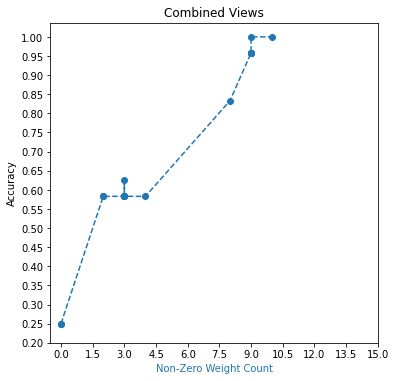

In [47]:
fig=plt.figure(figsize=(20, 10))

#Non-Zero Weight Count Plot
ax=fig.add_subplot(2, 4, 1, label="1")

ax.plot(nonzero_weight_cnt, accuracy, marker='o', color="C0", linestyle='dashed')

ax.set_xlabel("Non-Zero Weight Count", color="C0")
ax.set_ylabel("Accuracy", color="Black")
ax.tick_params(axis='x', colors="Black")
ax.tick_params(axis='y', colors="Black")
ax.set_yticks([x * 0.05 for x in range(4, 21)])
# ax.set_yticks([x * 0.05 for x in range(4, 21)])
ax.set_xticks(np.linspace(0,15,11))

ax.set_title("Combined Views")

fig.tight_layout()

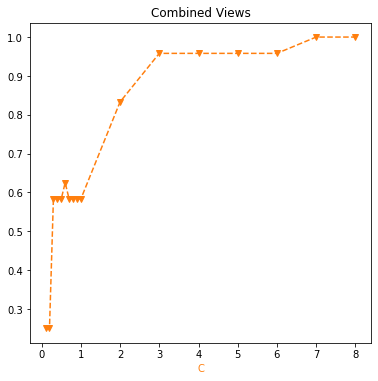

In [48]:
fig=plt.figure(figsize=(20, 10))

#C Value Line
ax2=fig.add_subplot(2, 4, 1, label="2")

ax2.plot(regularizers, accuracy, marker='v', color="C1", linestyle='dashed')

ax2.set_xlabel('C', color="C1") 
ax2.set_ylabel('')
ax2.tick_params(axis='x', colors="Black")
ax.set_yticks([x * 0.05 for x in range(4, 21)])
# ax2.set_yticks([x * 0.05 for x in range(4, 21)])
ax.set_xticks(np.linspace(0,15,11))

ax2.set_title("Combined Views")

fig.tight_layout()

In [49]:
###Train only on features from above, across different regularizers and on ALL VIEWS

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #####
    
    #Get "Useful Features" from Current view using Center of Intervals
    strip_row_avg = strip_row_avg[center_of_actual_intervals]

    #####

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        tol=5e-3,
                        C=r_c)

        #Print Model Params
        # print("Model Params: "+str(model.get_params()))

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
    # display(results)

View 1
View 2
View 3
View 4
View 5
View 6
View 7
View 8


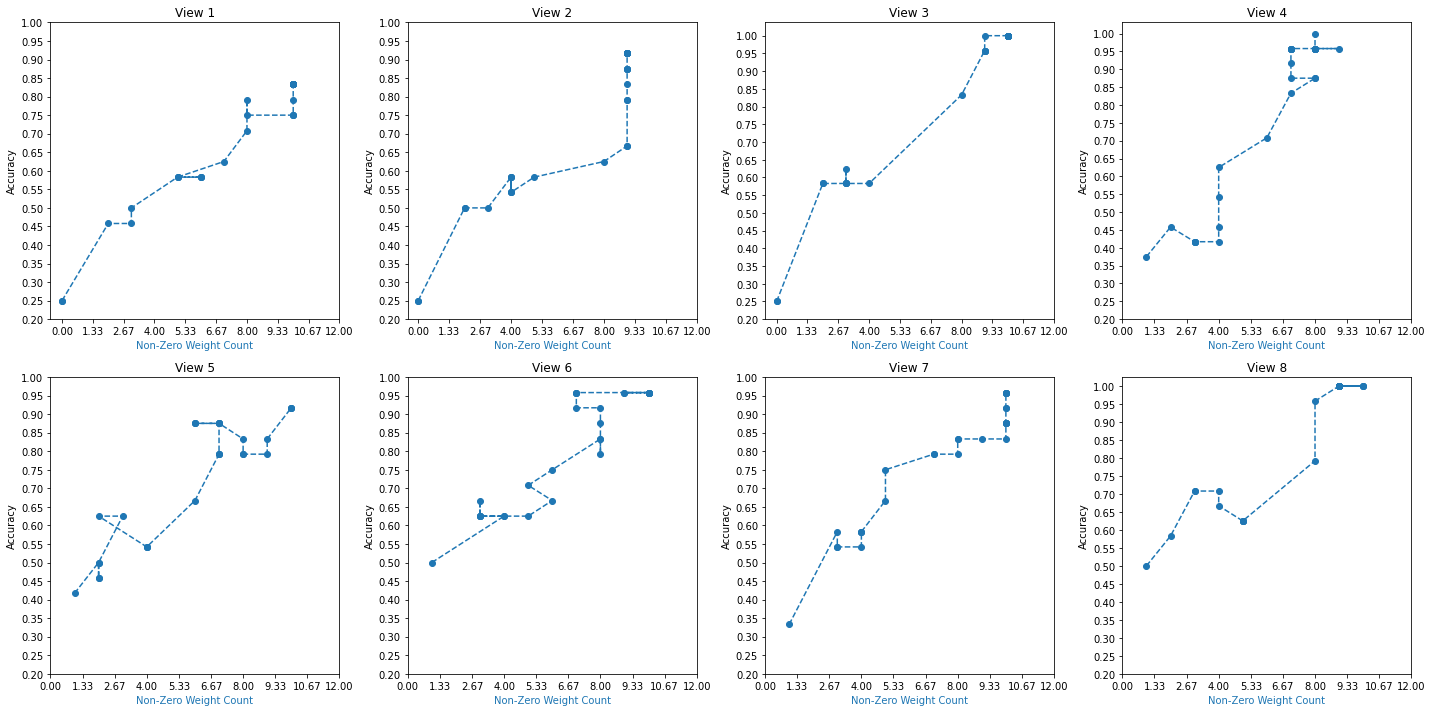

In [50]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #Non-Zero Weight Count Plot
    ax=fig.add_subplot(2, 4, j+1, label="1")

    ax.plot(all_nonzero_weight_cnts[j], all_accuracies[j], marker='o', color="C0", linestyle='dashed')

    ax.set_xlabel("Non-Zero Weight Count", color="C0")
    ax.set_ylabel("Accuracy", color="Black")
    ax.tick_params(axis='x', colors="Black")
    ax.tick_params(axis='y', colors="Black")
    ax.set_yticks([x * 0.05 for x in range(4, 21)])
    ax.set_xticks(np.linspace(0,12,10))

    ax.set_title("View "+str(j+1))

fig.tight_layout()

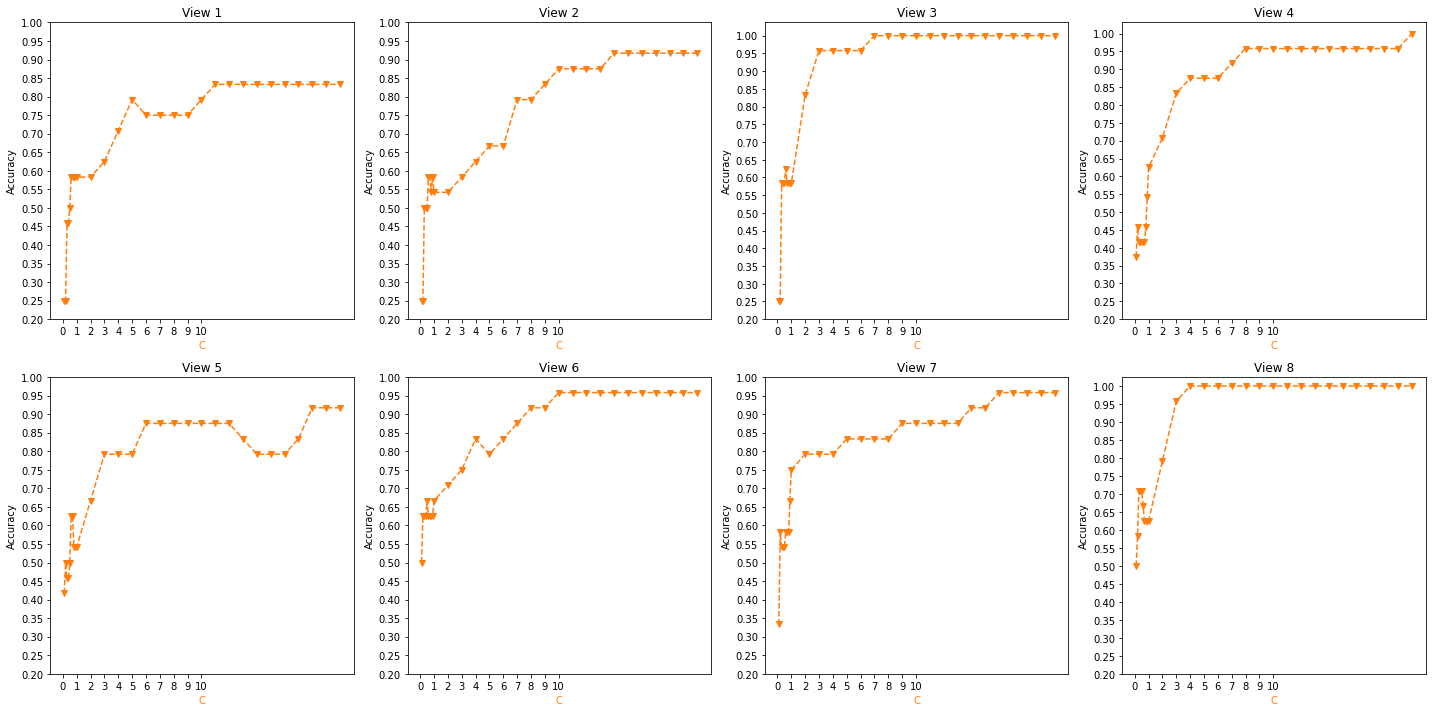

In [51]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #C Value Line
    ax2=fig.add_subplot(2, 4, j+1, label="2")

    ax2.plot(regularizers, all_accuracies[j], marker='v', color="C1", linestyle='dashed')

    # ax2.xaxis.tick_top()
    ax2.set_xlabel('C', color="C1") 
    ax2.set_ylabel("Accuracy", color="Black")
    ax2.tick_params(axis='x', colors="Black")
    ax2.set_yticks([x * 0.05 for x in range(4, 21)])
    ax2.set_xticks(np.linspace(0,10,11))
    # ax2.xaxis.set_label_position('top')

    ax2.set_title("View "+str(j+1))

fig.tight_layout()

### Attempt 2 - Union of Overlapping Intervals where Intervals are Looser (2 values)
#### Also better optimize calculation of intervals (combine all important features before determining interavls)

In [52]:
#This is all of our important features
print(len(important_features_by_view))

8


In [53]:
# # Function to Extract intervals from an array of values
# # Expects list to be already sorted
# # Strictness is how far apart values can be to be considered 'adjacent'
# def interval_extract_loose(list, strictness):
#     length = len(list)
#     i = 0
#     while (i< length):
#         low = list[i]
#         while i <length-1 and list[i]+strictness >= list[i + 1]: # the 2 can be variable
#             i += 1
#         high = list[i]
#         if (high - low >= 1):
#             yield [low, high]
#         elif (high - low == 1):
#             yield [low, ]
#             yield [high, ]
#         else:
#             yield [low, ]
#         i += 1

In [54]:
#Combine all our View's 'Important Features' and Sort
combined_important_features = np.concatenate(important_features_by_view)
combined_important_features = np.sort(combined_important_features)
print(len(combined_important_features))

638


In [55]:
#Get intervals for sorted list of combined important features
all_possible_intervals = list(interval_extract_loose(combined_important_features,2))
# print(len(all_possible_intervals))
# print(all_possible_intervals)

In [56]:
#Print length of each interval
lengths_of_intervals = []
for item in all_possible_intervals:
    if len(item) == 2:
        lengths_of_intervals.append(item[1]-item[0])
print(lengths_of_intervals)

[34, 9, 2, 19, 10, 6, 5, 5, 3, 11, 2, 11, 5, 22, 13, 45, 3, 22, 5, 7, 15, 5, 3, 3, 14, 11, 18, 18, 7, 5, 4, 2, 3, 28, 1, 15, 9, 3, 8, 3, 2, 5, 3, 4, 6, 8]


In [57]:
#Create array of
    # 1) All individual Values from 'all_possible_intervals' 
    # AND Center of any actual intervals from above array
    # 2) Only Center values from real intervals

centers_and_individual_intervals_of_all_intervals = []
only_centers_of_all_intervals = []

for item in all_possible_intervals:
    if len(item) == 2:
        center = int(round( (item[0]+item[1]) / 2, 0))
        only_centers_of_all_intervals.append(center)
        centers_and_individual_intervals_of_all_intervals.append(center)
    else:
        centers_and_individual_intervals_of_all_intervals.append(item[0])

print(len(centers_and_individual_intervals_of_all_intervals))
print(len(only_centers_of_all_intervals))

51
46


In [58]:
# Append final column index to feature arrays which is 
# Target Column from original feature vector

#Get count of Original Features
original_number_of_features = len(multiview_strip_row_avg_list[0][0])

#Append count - 1 to end of new features
centers_and_individual_intervals_of_all_intervals.append(original_number_of_features-1)
only_centers_of_all_intervals.append(original_number_of_features-1)

In [59]:
###Train only on features from `only_centers_of_all_intervals`, 
# across different regularizers AND
# on ALL VIEWS

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.7,.8,.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,]

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #####
    
    #Get "Useful Features" from Current view using Center of Intervals
    strip_row_avg = strip_row_avg[only_centers_of_all_intervals]

    #####

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        tol=2e-3,
                        C=r_c)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
    # display(results)

    #Get index of first 100% Accuracy row
    first_perfect_row_index = results[results.Accuracy==1.0].first_valid_index()

    #Get row at first_perfect_row_index
    first_perfect_row = pd.DataFrame(results.iloc[first_perfect_row_index])

    #Transpose to row format
    # first_perfect_row = first_perfect_row.transpose()

    #Change index name to match view number
    first_perfect_row = first_perfect_row.rename(columns={first_perfect_row_index:i})

    #Display and Append
    # display(first_perfect_row)
    minimized_best_params.append(first_perfect_row)

View 1
View 2
View 3
View 4
View 5
View 6
View 7
View 8


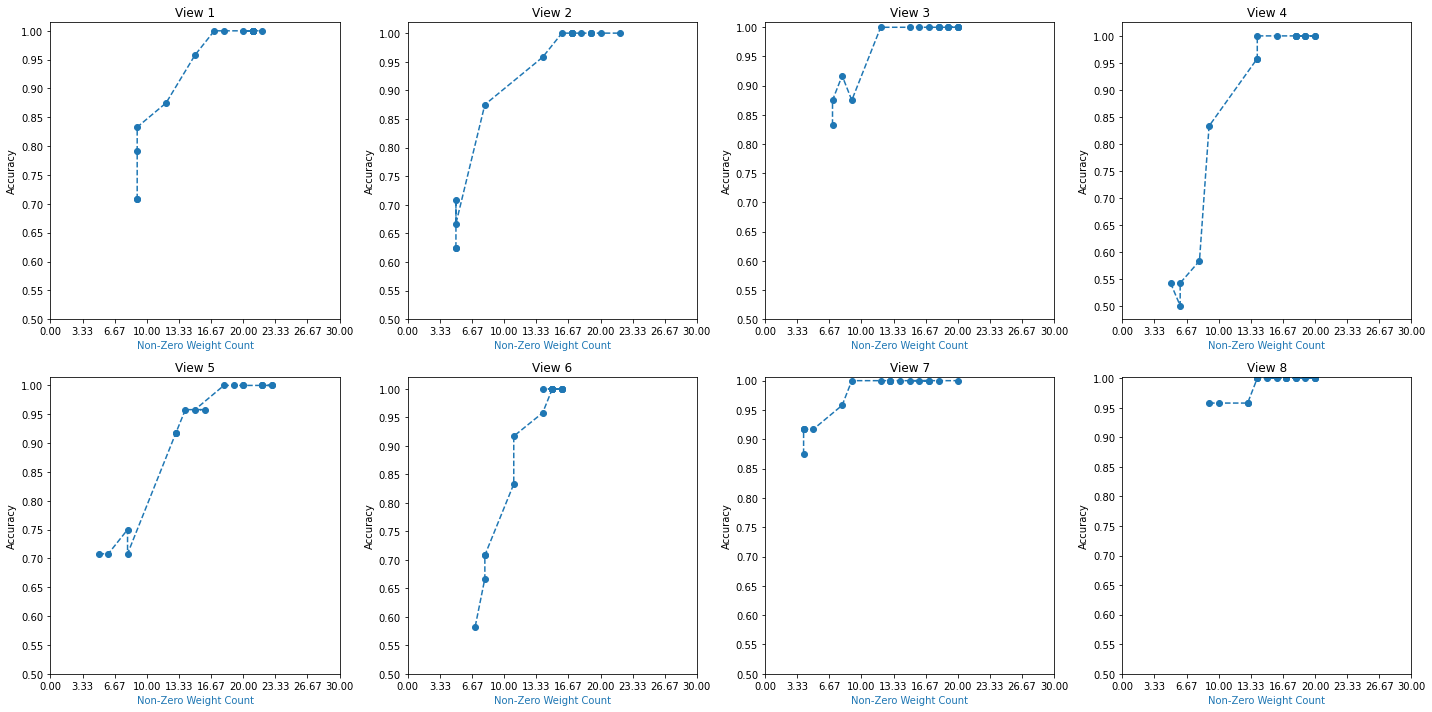

In [60]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #Non-Zero Weight Count Plot
    ax=fig.add_subplot(2, 4, j+1, label="1")

    ax.plot(all_nonzero_weight_cnts[j], all_accuracies[j], marker='o', color="C0", linestyle='dashed')

    ax.set_xlabel("Non-Zero Weight Count", color="C0")
    ax.set_ylabel("Accuracy", color="Black")
    ax.tick_params(axis='x', colors="Black")
    ax.tick_params(axis='y', colors="Black")
    ax.set_yticks([x * 0.05 for x in range(10, 21)])
    ax.set_xticks(np.linspace(0,30,10))

    ax.set_title("View "+str(j+1))

fig.tight_layout()

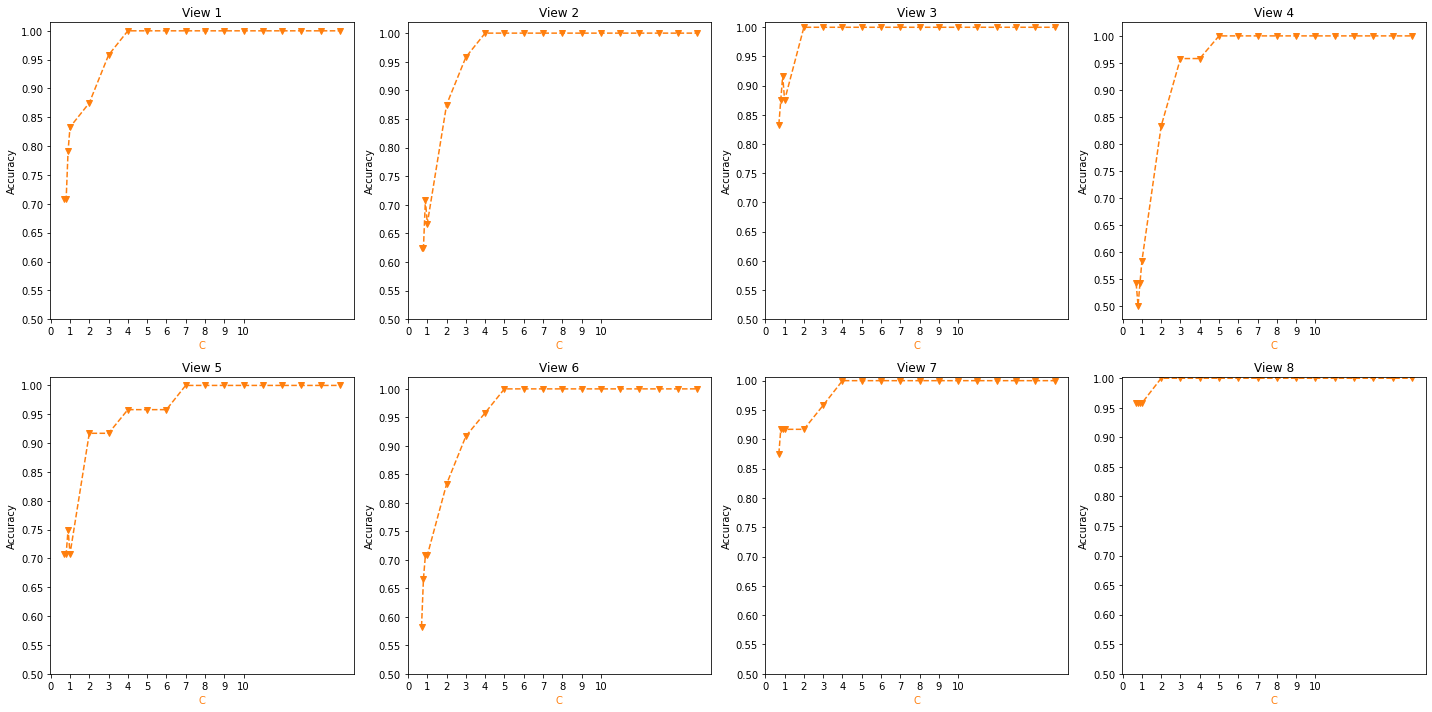

In [61]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #C Value Line
    ax2=fig.add_subplot(2, 4, j+1, label="2")

    ax2.plot(regularizers, all_accuracies[j], marker='v', color="C1", linestyle='dashed')

    # ax2.xaxis.tick_top()
    ax2.set_xlabel('C', color="C1") 
    ax2.set_ylabel("Accuracy", color="Black")
    ax2.tick_params(axis='x', colors="Black")
    ax2.set_yticks([x * 0.05 for x in range(10, 21)])
    ax2.set_xticks(np.linspace(0,10,11))
    # ax2.xaxis.set_label_position('top')

    ax2.set_title("View "+str(j+1))

fig.tight_layout()

In [62]:
###Train only on features from `centers_and_individual_intervals_of_all_intervals`, 
# across different regularizers AND
# on ALL VIEWS

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.7,.8,.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,]

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #####
    
    #Get "Useful Features" from Current view using Center of Intervals
    strip_row_avg = strip_row_avg[centers_and_individual_intervals_of_all_intervals]

    #####

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        tol=5e-3,
                        C=r_c)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
    # display(results)

    #Get index of first 100% Accuracy row
    first_perfect_row_index = results[results.Accuracy==1.0].first_valid_index()

    #Get row at first_perfect_row_index
    first_perfect_row = pd.DataFrame(results.iloc[first_perfect_row_index])

    #Transpose to row format
    # first_perfect_row = first_perfect_row.transpose()

    #Change index name to match view number
    first_perfect_row = first_perfect_row.rename(columns={first_perfect_row_index:i})

    #Display and Append
    # display(first_perfect_row)
    minimized_best_params.append(first_perfect_row)

View 1
View 2
View 3
View 4
View 5
View 6
View 7
View 8


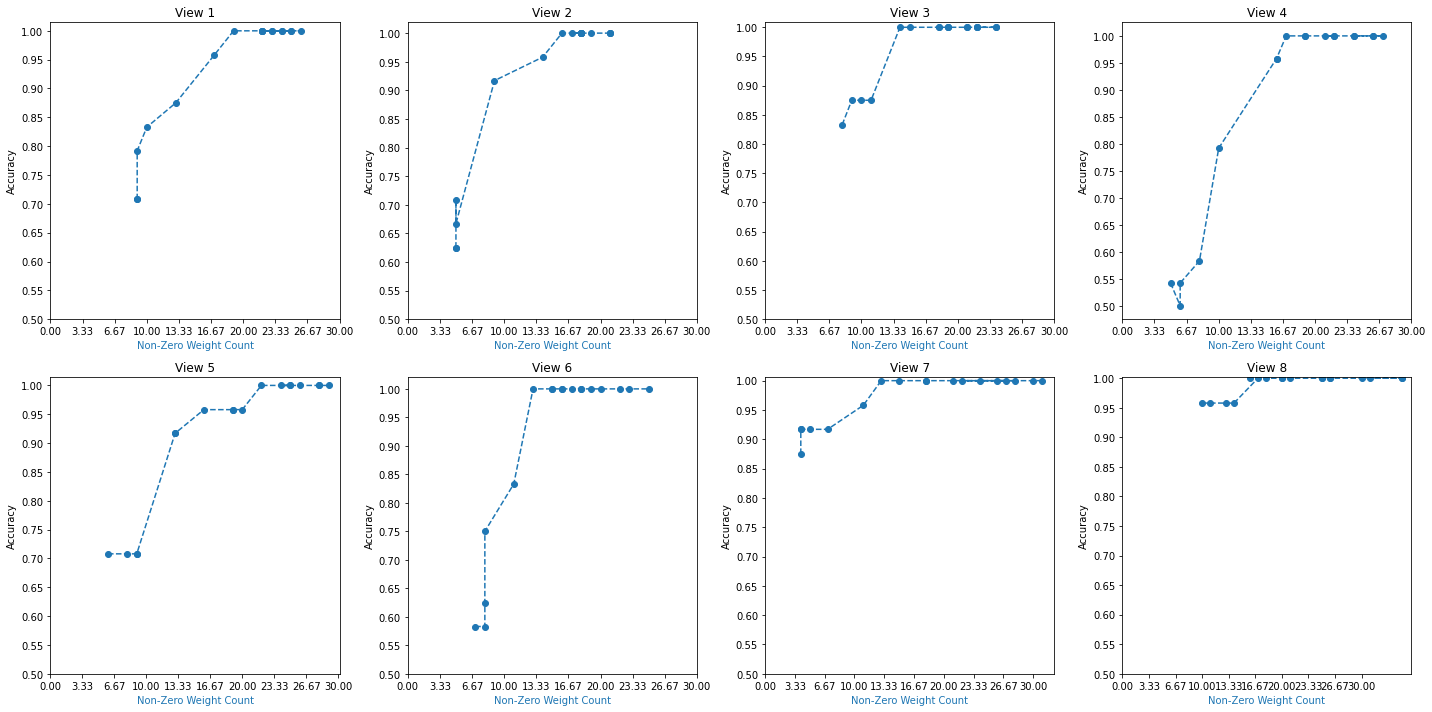

In [63]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #Non-Zero Weight Count Plot
    ax=fig.add_subplot(2, 4, j+1, label="1")

    ax.plot(all_nonzero_weight_cnts[j], all_accuracies[j], marker='o', color="C0", linestyle='dashed')

    ax.set_xlabel("Non-Zero Weight Count", color="C0")
    ax.set_ylabel("Accuracy", color="Black")
    ax.tick_params(axis='x', colors="Black")
    ax.tick_params(axis='y', colors="Black")
    ax.set_yticks([x * 0.05 for x in range(10, 21)])
    ax.set_xticks(np.linspace(0,30,10))

    ax.set_title("View "+str(j+1))

fig.tight_layout()

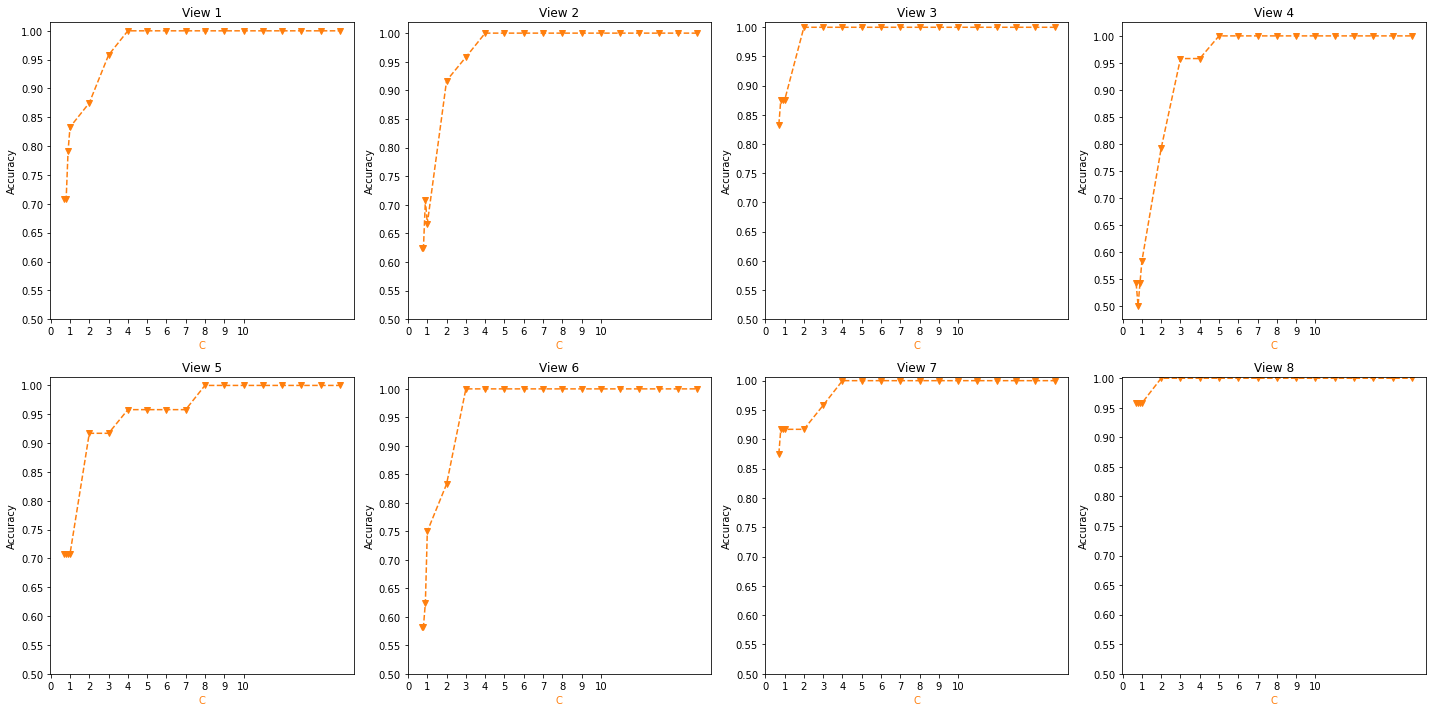

In [64]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #C Value Line
    ax2=fig.add_subplot(2, 4, j+1, label="2")

    ax2.plot(regularizers, all_accuracies[j], marker='v', color="C1", linestyle='dashed')

    # ax2.xaxis.tick_top()
    ax2.set_xlabel('C', color="C1") 
    ax2.set_ylabel("Accuracy", color="Black")
    ax2.tick_params(axis='x', colors="Black")
    ax2.set_yticks([x * 0.05 for x in range(10, 21)])
    ax2.set_xticks(np.linspace(0,10,11))
    # ax2.xaxis.set_label_position('top')

    ax2.set_title("View "+str(j+1))

fig.tight_layout()

### Attempt 2.5 - Union of Overlapping Intervals where Intervals are Strictly set to 1 BUT we are using optimized Merging

In [65]:
#Get intervals for sorted list of combined important features
all_possible_intervals = list(interval_extract_loose(combined_important_features,1))
# print(len(all_possible_intervals))
# print(all_possible_intervals)

In [66]:
#Print length of each interval
lengths_of_intervals = []
for item in all_possible_intervals:
    if len(item) == 2:
        lengths_of_intervals.append(item[1]-item[0])
print(lengths_of_intervals)

[15, 2, 1, 6, 9, 2, 2, 15, 10, 4, 5, 5, 3, 7, 2, 2, 11, 5, 2, 2, 12, 13, 45, 3, 22, 5, 7, 15, 5, 3, 3, 14, 11, 6, 10, 18, 7, 3, 2, 2, 3, 2, 2, 8, 6, 1, 9, 4, 5, 2, 3, 8, 3, 2, 1, 2, 3, 4, 6, 2, 2]


In [67]:
#Create array of
    # 1) All individual Values from 'all_possible_intervals' 
    # AND Center of any actual intervals from above array
    # 2) Only Center values from real intervals

centers_and_individual_intervals_of_all_intervals = []
only_centers_of_all_intervals = []

for item in all_possible_intervals:
    if len(item) == 2:
        center = int(round( (item[0]+item[1]) / 2, 0))
        only_centers_of_all_intervals.append(center)
        centers_and_individual_intervals_of_all_intervals.append(center)
    else:
        centers_and_individual_intervals_of_all_intervals.append(item[0])

print(len(centers_and_individual_intervals_of_all_intervals))
print(len(only_centers_of_all_intervals))

75
61


In [68]:
# Append final column index to feature arrays which is 
# Target Column from original feature vector

#Get count of Original Features
original_number_of_features = len(multiview_strip_row_avg_list[0][0])

#Append count - 1 to end of new features
centers_and_individual_intervals_of_all_intervals.append(original_number_of_features-1)
only_centers_of_all_intervals.append(original_number_of_features-1)

In [69]:
###Train only on features from `only_centers_of_all_intervals`, 
# across different regularizers AND
# on ALL VIEWS

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.7,.8,.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,]

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #####
    
    #Get "Useful Features" from Current view using Center of Intervals
    strip_row_avg = strip_row_avg[only_centers_of_all_intervals]

    #####

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        tol=2e-3,
                        C=r_c)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
    # display(results)

    #Get index of first 100% Accuracy row
    first_perfect_row_index = results[results.Accuracy==1.0].first_valid_index()

    #Get row at first_perfect_row_index
    first_perfect_row = pd.DataFrame(results.iloc[first_perfect_row_index])

    #Transpose to row format
    # first_perfect_row = first_perfect_row.transpose()

    #Change index name to match view number
    first_perfect_row = first_perfect_row.rename(columns={first_perfect_row_index:i})

    #Display and Append
    # display(first_perfect_row)
    minimized_best_params.append(first_perfect_row)

View 1
View 2
View 3
View 4
View 5
View 6
View 7
View 8


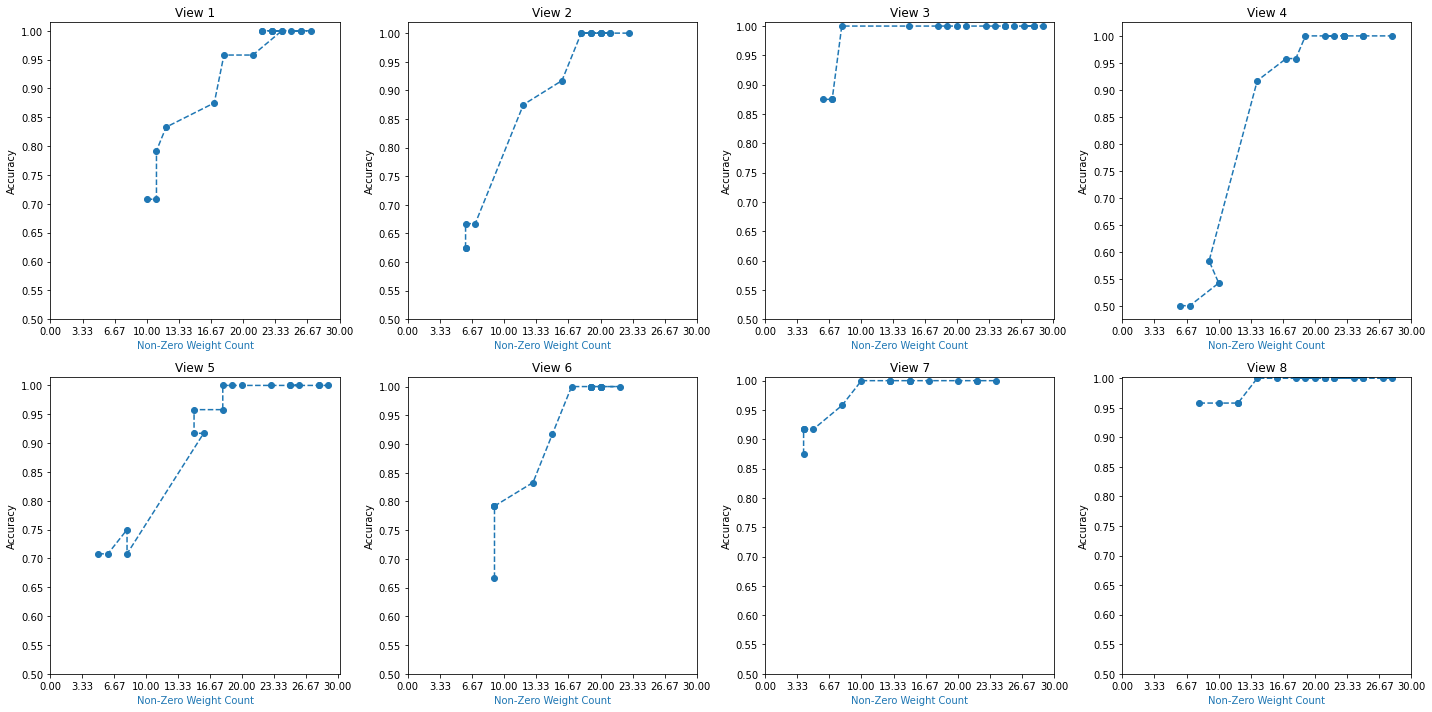

In [70]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #Non-Zero Weight Count Plot
    ax=fig.add_subplot(2, 4, j+1, label="1")

    ax.plot(all_nonzero_weight_cnts[j], all_accuracies[j], marker='o', color="C0", linestyle='dashed')

    ax.set_xlabel("Non-Zero Weight Count", color="C0")
    ax.set_ylabel("Accuracy", color="Black")
    ax.tick_params(axis='x', colors="Black")
    ax.tick_params(axis='y', colors="Black")
    ax.set_yticks([x * 0.05 for x in range(10, 21)])
    ax.set_xticks(np.linspace(0,30,10))

    ax.set_title("View "+str(j+1))

fig.tight_layout()

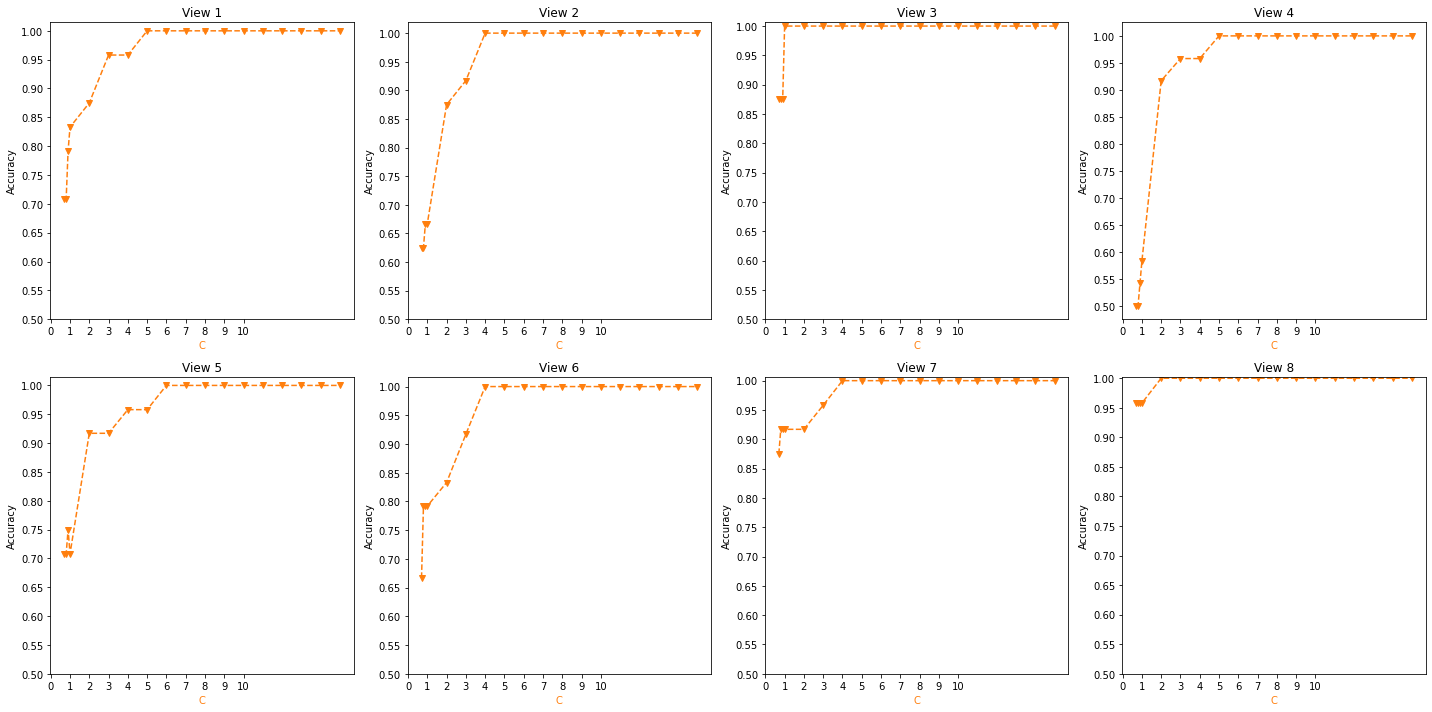

In [71]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #C Value Line
    ax2=fig.add_subplot(2, 4, j+1, label="2")

    ax2.plot(regularizers, all_accuracies[j], marker='v', color="C1", linestyle='dashed')

    # ax2.xaxis.tick_top()
    ax2.set_xlabel('C', color="C1") 
    ax2.set_ylabel("Accuracy", color="Black")
    ax2.tick_params(axis='x', colors="Black")
    ax2.set_yticks([x * 0.05 for x in range(10, 21)])
    ax2.set_xticks(np.linspace(0,10,11))
    # ax2.xaxis.set_label_position('top')

    ax2.set_title("View "+str(j+1))

fig.tight_layout()

In [72]:
###Train only on features from `centers_and_individual_intervals_of_all_intervals`, 
# across different regularizers AND
# on ALL VIEWS

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.7,.8,.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,]

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #####
    
    #Get "Useful Features" from Current view using Center of Intervals
    strip_row_avg = strip_row_avg[centers_and_individual_intervals_of_all_intervals]

    #####

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        tol=5e-3,
                        C=r_c)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
    # display(results)

    #Get index of first 100% Accuracy row
    first_perfect_row_index = results[results.Accuracy==1.0].first_valid_index()

    #Get row at first_perfect_row_index
    first_perfect_row = pd.DataFrame(results.iloc[first_perfect_row_index])

    #Transpose to row format
    # first_perfect_row = first_perfect_row.transpose()

    #Change index name to match view number
    first_perfect_row = first_perfect_row.rename(columns={first_perfect_row_index:i})

    #Display and Append
    # display(first_perfect_row)
    minimized_best_params.append(first_perfect_row)

View 1
View 2
View 3
View 4
View 5
View 6
View 7
View 8


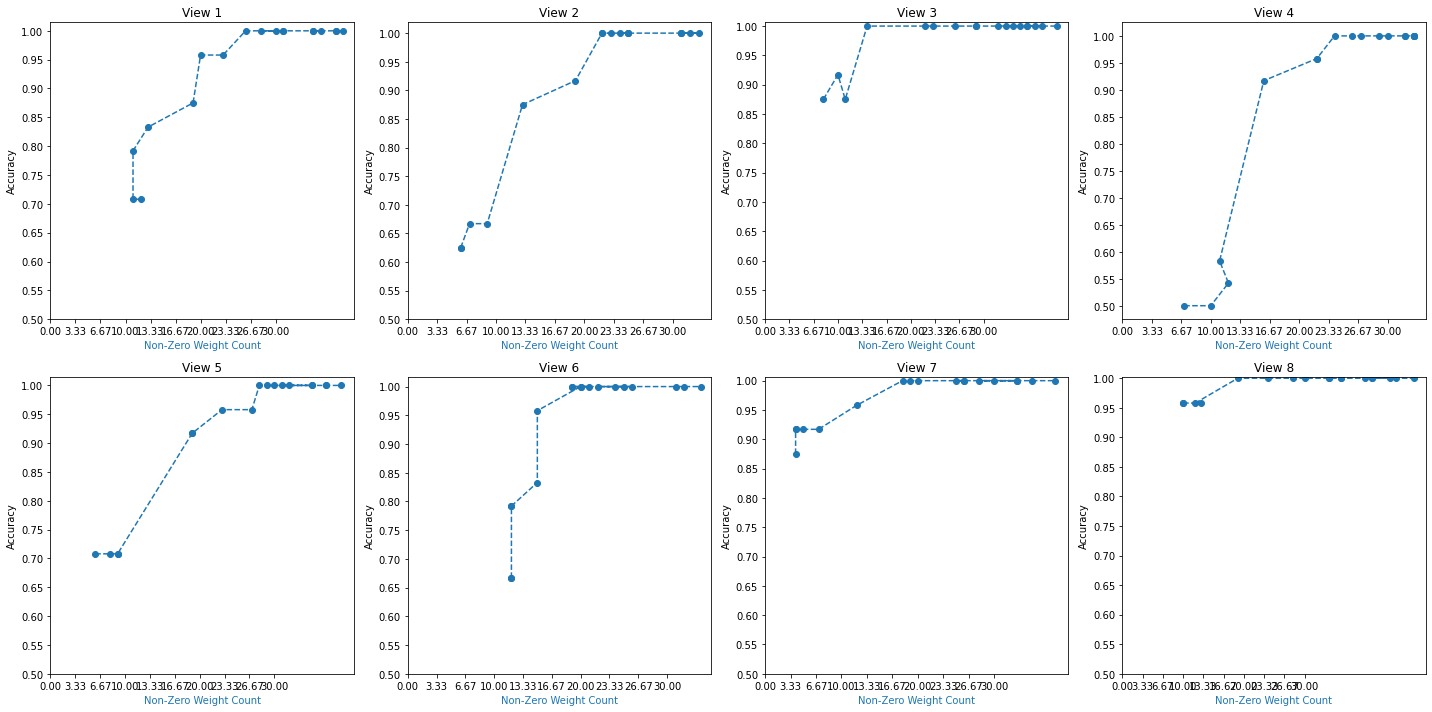

In [73]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #Non-Zero Weight Count Plot
    ax=fig.add_subplot(2, 4, j+1, label="1")

    ax.plot(all_nonzero_weight_cnts[j], all_accuracies[j], marker='o', color="C0", linestyle='dashed')

    ax.set_xlabel("Non-Zero Weight Count", color="C0")
    ax.set_ylabel("Accuracy", color="Black")
    ax.tick_params(axis='x', colors="Black")
    ax.tick_params(axis='y', colors="Black")
    ax.set_yticks([x * 0.05 for x in range(10, 21)])
    ax.set_xticks(np.linspace(0,30,10))

    ax.set_title("View "+str(j+1))

fig.tight_layout()

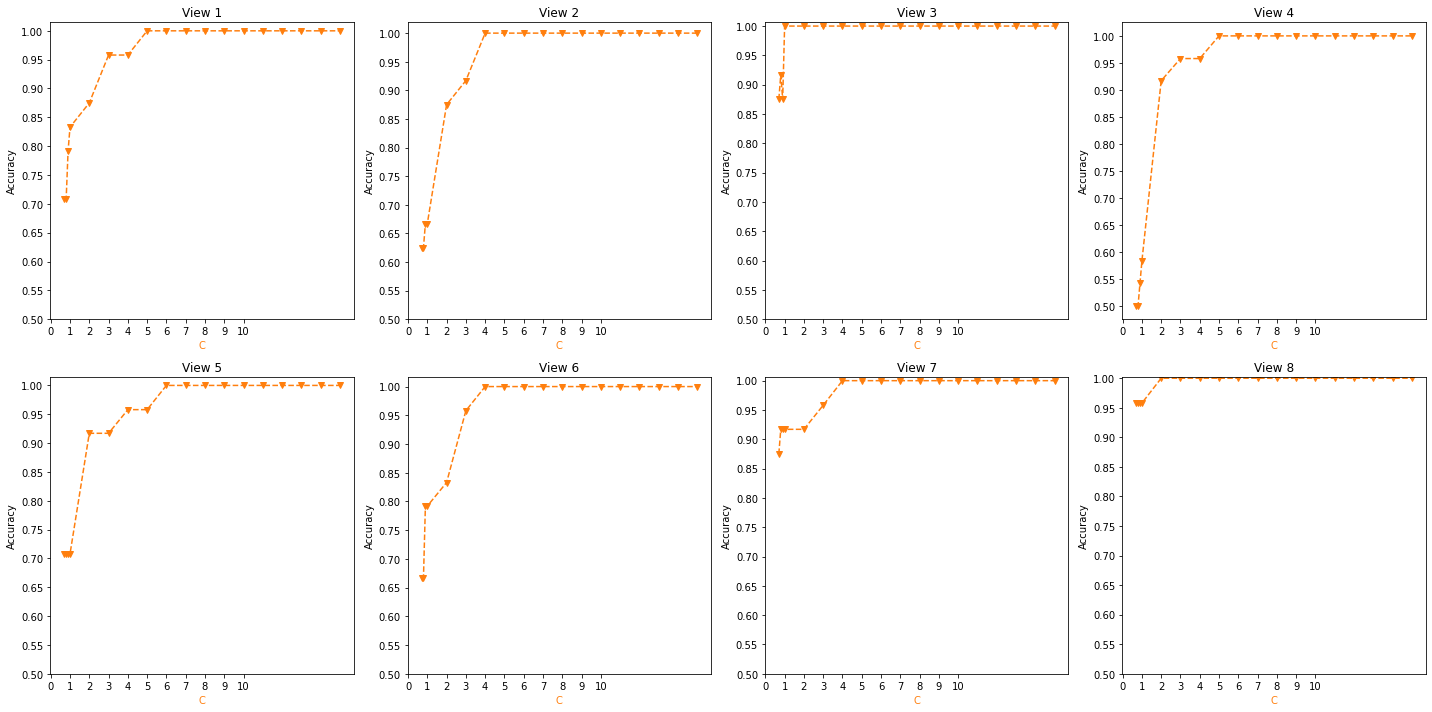

In [74]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #C Value Line
    ax2=fig.add_subplot(2, 4, j+1, label="2")

    ax2.plot(regularizers, all_accuracies[j], marker='v', color="C1", linestyle='dashed')

    # ax2.xaxis.tick_top()
    ax2.set_xlabel('C', color="C1") 
    ax2.set_ylabel("Accuracy", color="Black")
    ax2.tick_params(axis='x', colors="Black")
    ax2.set_yticks([x * 0.05 for x in range(10, 21)])
    ax2.set_xticks(np.linspace(0,10,11))
    # ax2.xaxis.set_label_position('top')

    ax2.set_title("View "+str(j+1))

fig.tight_layout()

### Attempt 3 - Union of Overlapping Intervals where Intervals are Looser (3 values apart)

In [75]:
#Get intervals for sorted list of combined important features
all_possible_intervals = list(interval_extract_loose(combined_important_features,3))
# print(len(all_possible_intervals))
# print(all_possible_intervals)

In [76]:
#Print length of each interval
lengths_of_intervals = []
for item in all_possible_intervals:
    if len(item) == 2:
        lengths_of_intervals.append(item[1]-item[0])
print(lengths_of_intervals)

[46, 2, 19, 10, 6, 5, 5, 3, 11, 2, 11, 5, 22, 13, 48, 3, 40, 15, 5, 3, 3, 28, 18, 28, 5, 4, 2, 6, 28, 19, 15, 14, 2, 5, 10, 6, 8]


In [77]:
#Create array of
    # 1) All individual Values from 'all_possible_intervals' 
    # AND Center of any actual intervals from above array
    # 2) Only Center values from real intervals

centers_and_individual_intervals_of_all_intervals = []
only_centers_of_all_intervals = []

for item in all_possible_intervals:
    if len(item) == 2:
        center = int(round( (item[0]+item[1]) / 2, 0))
        only_centers_of_all_intervals.append(center)
        centers_and_individual_intervals_of_all_intervals.append(center)
    else:
        centers_and_individual_intervals_of_all_intervals.append(item[0])

print(len(centers_and_individual_intervals_of_all_intervals))
print(len(only_centers_of_all_intervals))

40
37


In [78]:
# Append final column index to feature arrays which is 
# Target Column from original feature vector

#Get count of Original Features
original_number_of_features = len(multiview_strip_row_avg_list[0][0])

#Append count - 1 to end of new features
centers_and_individual_intervals_of_all_intervals.append(original_number_of_features-1)
only_centers_of_all_intervals.append(original_number_of_features-1)

In [79]:
###Train only on features from `only_centers_of_all_intervals`, 
# across different regularizers AND
# on ALL VIEWS

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.7,.8,.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,]

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #####
    
    #Get "Useful Features" from Current view using Center of Intervals
    strip_row_avg = strip_row_avg[only_centers_of_all_intervals]

    #####

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        tol=2e-5,
                        C=r_c)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
    # display(results)

    #Get index of first 100% Accuracy row
    first_perfect_row_index = results[results.Accuracy==1.0].first_valid_index()

    #Get row at first_perfect_row_index
    first_perfect_row = pd.DataFrame(results.iloc[first_perfect_row_index])

    #Transpose to row format
    # first_perfect_row = first_perfect_row.transpose()

    #Change index name to match view number
    first_perfect_row = first_perfect_row.rename(columns={first_perfect_row_index:i})

    #Display and Append
    display(first_perfect_row)
    minimized_best_params.append(first_perfect_row)

View 1


,0
Accuracy,1.0
Regularizers,5.0
Unique Non-Zero Weight Count,18.0


View 2


,1
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,16.0


View 3


,2
Accuracy,1.0
Regularizers,3.0
Unique Non-Zero Weight Count,12.0


View 4


,3
Accuracy,1.0
Regularizers,6.0
Unique Non-Zero Weight Count,14.0


View 5


,4
Accuracy,1.0
Regularizers,14.0
Unique Non-Zero Weight Count,14.0


View 6


,5
Accuracy,1.0
Regularizers,6.0
Unique Non-Zero Weight Count,15.0


View 7


,6
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,10.0


View 8


,7
Accuracy,1.0
Regularizers,5.0
Unique Non-Zero Weight Count,14.0


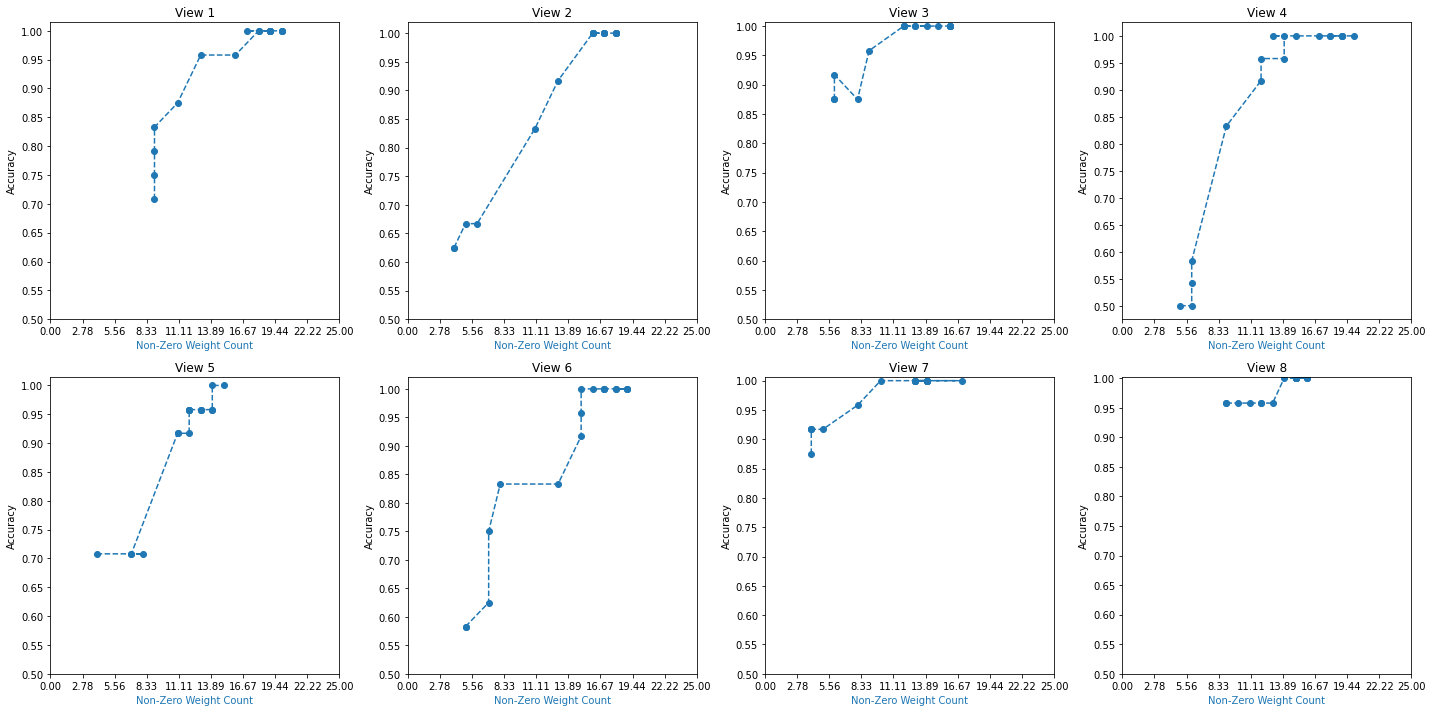

In [80]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #Non-Zero Weight Count Plot
    ax=fig.add_subplot(2, 4, j+1, label="1")

    ax.plot(all_nonzero_weight_cnts[j], all_accuracies[j], marker='o', color="C0", linestyle='dashed')

    ax.set_xlabel("Non-Zero Weight Count", color="C0")
    ax.set_ylabel("Accuracy", color="Black")
    ax.tick_params(axis='x', colors="Black")
    ax.tick_params(axis='y', colors="Black")
    ax.set_yticks([x * 0.05 for x in range(10, 21)])
    ax.set_xticks(np.linspace(0,25,10))

    ax.set_title("View "+str(j+1))

fig.tight_layout()

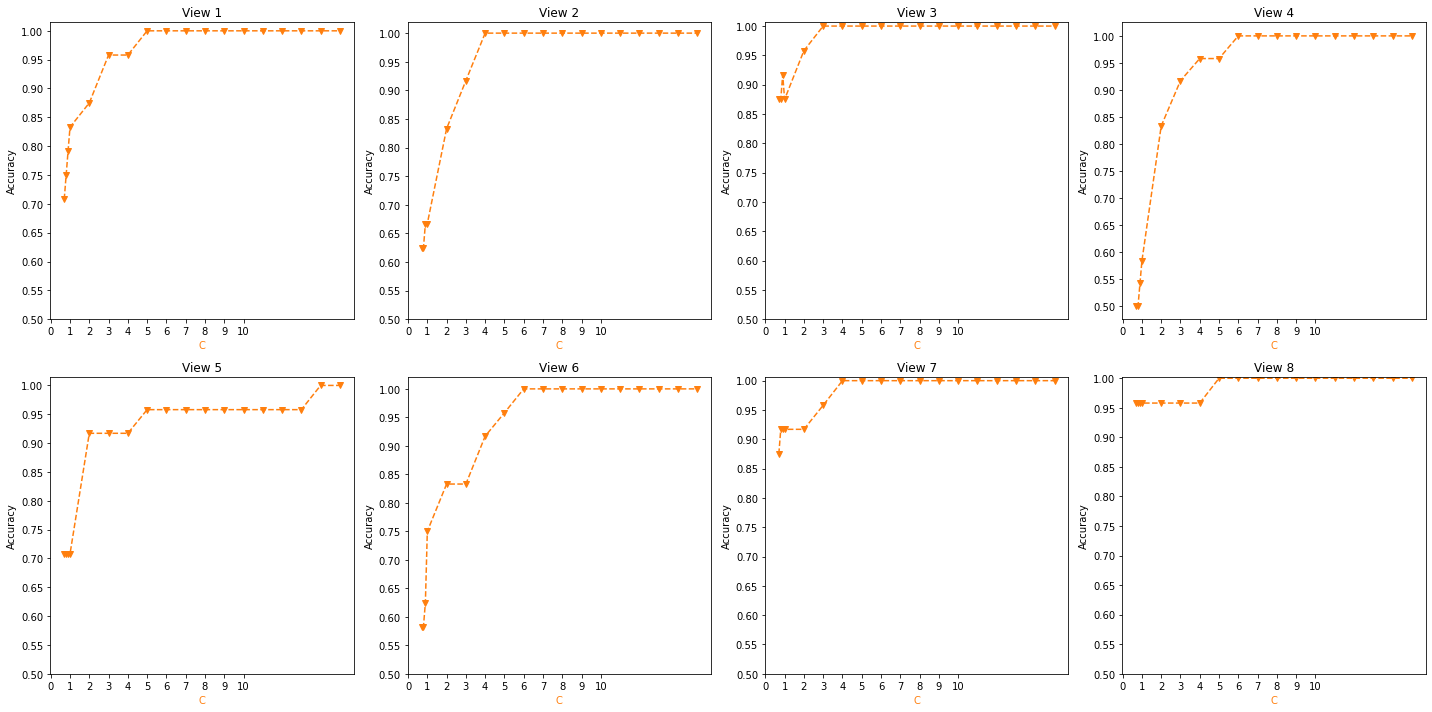

In [81]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #C Value Line
    ax2=fig.add_subplot(2, 4, j+1, label="2")

    ax2.plot(regularizers, all_accuracies[j], marker='v', color="C1", linestyle='dashed')

    # ax2.xaxis.tick_top()
    ax2.set_xlabel('C', color="C1") 
    ax2.set_ylabel("Accuracy", color="Black")
    ax2.tick_params(axis='x', colors="Black")
    ax2.set_yticks([x * 0.05 for x in range(10, 21)])
    ax2.set_xticks(np.linspace(0,10,11))
    # ax2.xaxis.set_label_position('top')

    ax2.set_title("View "+str(j+1))

fig.tight_layout()

In [82]:
###Train only on features from `centers_and_individual_intervals_of_all_intervals`, 
# across different regularizers AND
# on ALL VIEWS

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.7,.8,.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,]

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #####
    
    #Get "Useful Features" from Current view using Center of Intervals
    strip_row_avg = strip_row_avg[centers_and_individual_intervals_of_all_intervals]

    #####

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        tol=5e-3,
                        C=r_c)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
    # display(results)

    #Get index of first 100% Accuracy row
    first_perfect_row_index = results[results.Accuracy==1.0].first_valid_index()

    #Get row at first_perfect_row_index
    first_perfect_row = pd.DataFrame(results.iloc[first_perfect_row_index])

    #Transpose to row format
    # first_perfect_row = first_perfect_row.transpose()

    #Change index name to match view number
    first_perfect_row = first_perfect_row.rename(columns={first_perfect_row_index:i})

    #Display and Append
    display(first_perfect_row)
    minimized_best_params.append(first_perfect_row)

View 1


,0
Accuracy,1.0
Regularizers,5.0
Unique Non-Zero Weight Count,21.0


View 2


,1
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,18.0


View 3


,2
Accuracy,1.0
Regularizers,3.0
Unique Non-Zero Weight Count,12.0


View 4


,3
Accuracy,1.0
Regularizers,6.0
Unique Non-Zero Weight Count,18.0


View 5


,4
Accuracy,1.0
Regularizers,11.0
Unique Non-Zero Weight Count,16.0


View 6


,5
Accuracy,1.0
Regularizers,6.0
Unique Non-Zero Weight Count,18.0


View 7


,6
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,13.0


View 8


,7
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,23.0


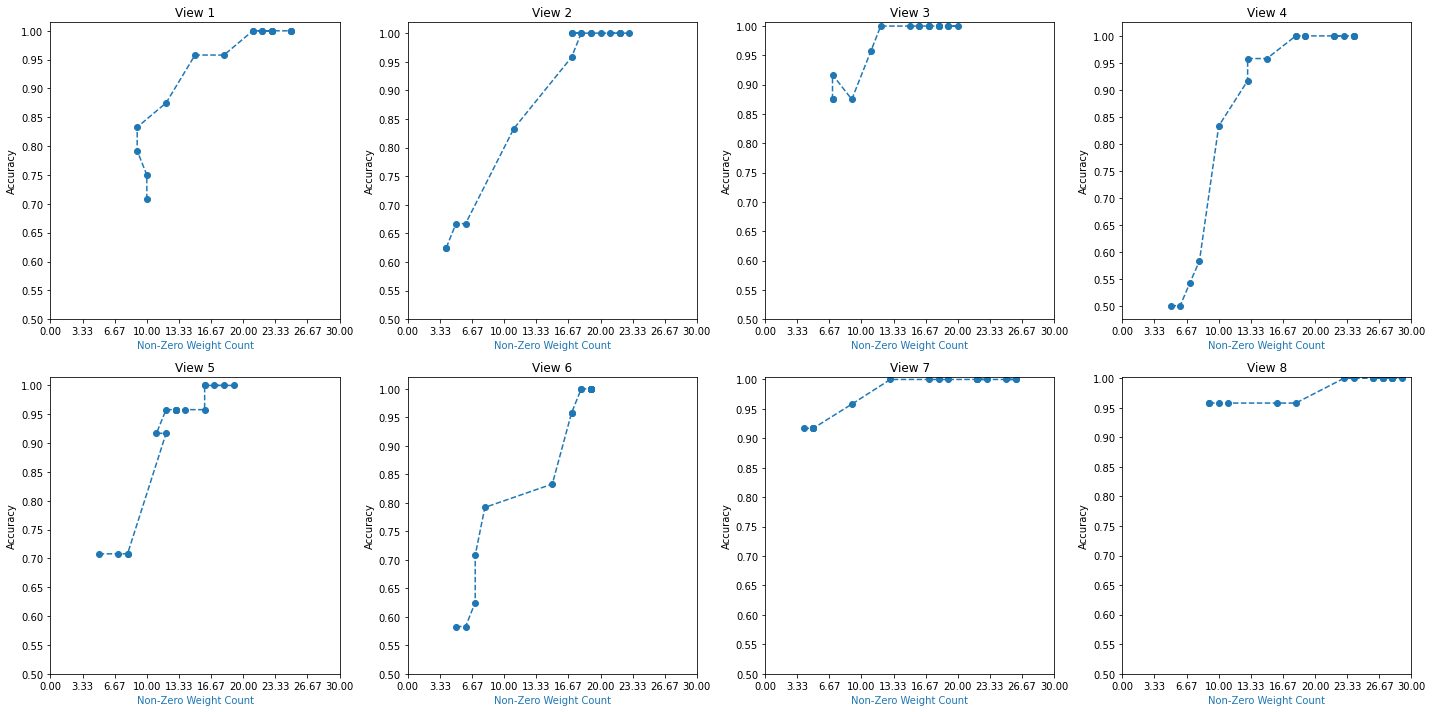

In [83]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #Non-Zero Weight Count Plot
    ax=fig.add_subplot(2, 4, j+1, label="1")

    ax.plot(all_nonzero_weight_cnts[j], all_accuracies[j], marker='o', color="C0", linestyle='dashed')

    ax.set_xlabel("Non-Zero Weight Count", color="C0")
    ax.set_ylabel("Accuracy", color="Black")
    ax.tick_params(axis='x', colors="Black")
    ax.tick_params(axis='y', colors="Black")
    ax.set_yticks([x * 0.05 for x in range(10, 21)])
    ax.set_xticks(np.linspace(0,30,10))

    ax.set_title("View "+str(j+1))

fig.tight_layout()

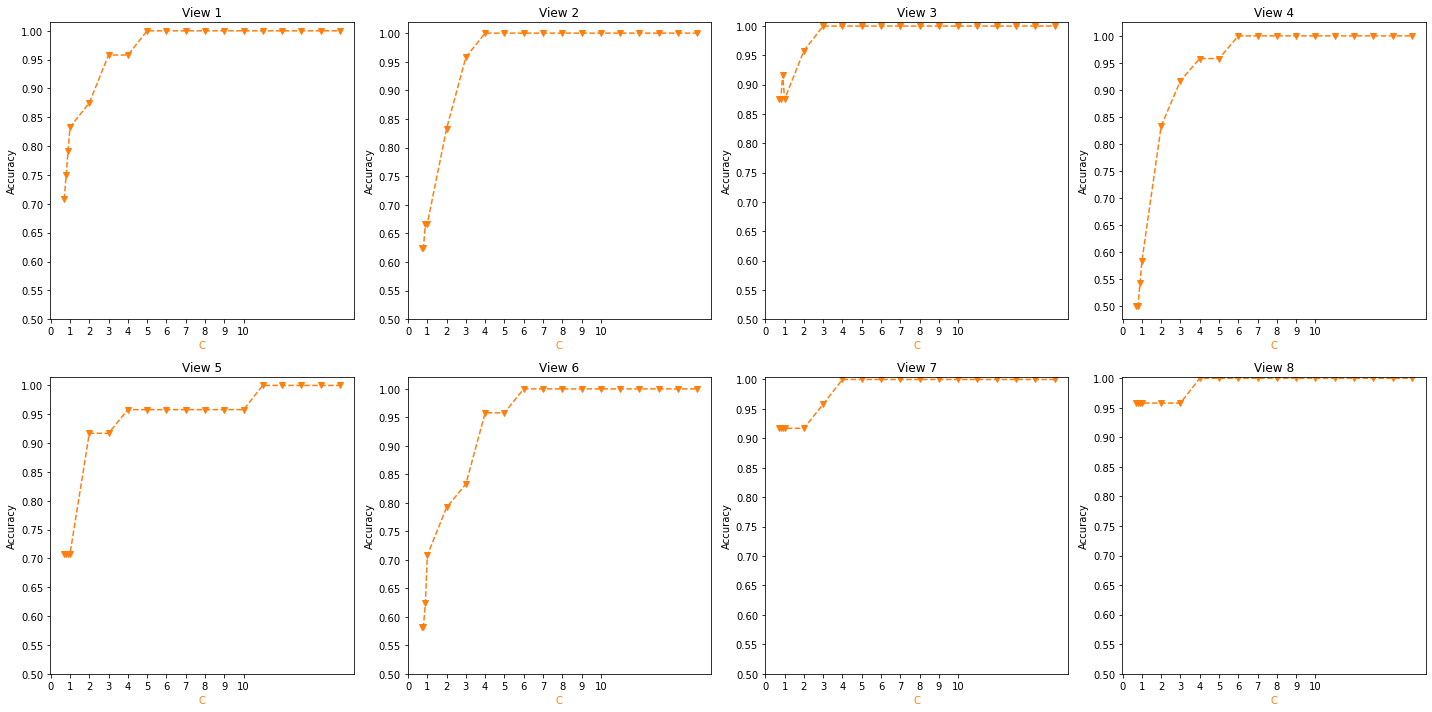

In [84]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #C Value Line
    ax2=fig.add_subplot(2, 4, j+1, label="2")

    ax2.plot(regularizers, all_accuracies[j], marker='v', color="C1", linestyle='dashed')

    # ax2.xaxis.tick_top()
    ax2.set_xlabel('C', color="C1") 
    ax2.set_ylabel("Accuracy", color="Black")
    ax2.tick_params(axis='x', colors="Black")
    ax2.set_yticks([x * 0.05 for x in range(10, 21)])
    ax2.set_xticks(np.linspace(0,10,11))
    # ax2.xaxis.set_label_position('top')

    ax2.set_title("View "+str(j+1))

fig.tight_layout()

### Attempt 4 - Union of Overlapping Intervals where Intervals are Looser (5 values apart)

In [85]:
#Get intervals for sorted list of combined important features
all_possible_intervals = list(interval_extract_loose(combined_important_features,5))
# print(len(all_possible_intervals))
# print(all_possible_intervals)

In [86]:
#Print length of each interval
lengths_of_intervals = []
for item in all_possible_intervals:
    if len(item) == 2:
        lengths_of_intervals.append(item[1]-item[0])
print(lengths_of_intervals)

[46, 2, 19, 31, 5, 3, 32, 5, 22, 65, 3, 40, 24, 3, 3, 50, 37, 4, 13, 28, 38, 14, 11, 38]


In [87]:
#Create array of
    # 1) All individual Values from 'all_possible_intervals' 
    # AND Center of any actual intervals from above array
    # 2) Only Center values from real intervals

centers_and_individual_intervals_of_all_intervals = []
only_centers_of_all_intervals = []

for item in all_possible_intervals:
    if len(item) == 2:
        center = int(round( (item[0]+item[1]) / 2, 0))
        only_centers_of_all_intervals.append(center)
        centers_and_individual_intervals_of_all_intervals.append(center)
    else:
        centers_and_individual_intervals_of_all_intervals.append(item[0])

print(len(centers_and_individual_intervals_of_all_intervals))
print(len(only_centers_of_all_intervals))

26
24


In [88]:
# Append final column index to feature arrays which is 
# Target Column from original feature vector

#Get count of Original Features
original_number_of_features = len(multiview_strip_row_avg_list[0][0])

#Append count - 1 to end of new features
centers_and_individual_intervals_of_all_intervals.append(original_number_of_features-1)
only_centers_of_all_intervals.append(original_number_of_features-1)

In [89]:
###Train only on features from `only_centers_of_all_intervals`, 
# across different regularizers AND
# on ALL VIEWS

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.7,.8,.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #####
    
    #Get "Useful Features" from Current view using Center of Intervals
    strip_row_avg = strip_row_avg[only_centers_of_all_intervals]

    #####

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        tol=2e-3,
                        C=r_c)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
    # display(results)

    #Get index of first 100% Accuracy row
    first_perfect_row_index = results[results.Accuracy==1.0].first_valid_index()
    if first_perfect_row_index:

        #Get row at first_perfect_row_index
        first_perfect_row = pd.DataFrame(results.iloc[first_perfect_row_index])

        #Transpose to row format
        # first_perfect_row = first_perfect_row.transpose()

        #Change index name to match view number
        first_perfect_row = first_perfect_row.rename(columns={first_perfect_row_index:i})

        #Display and Append
        display(first_perfect_row)
        minimized_best_params.append(first_perfect_row)

View 1


,0
Accuracy,1.0
Regularizers,8.0
Unique Non-Zero Weight Count,17.0


View 2


,1
Accuracy,1.0
Regularizers,6.0
Unique Non-Zero Weight Count,16.0


View 3


,2
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,10.0


View 4


,3
Accuracy,1.0
Regularizers,6.0
Unique Non-Zero Weight Count,12.0


View 5
View 6


,5
Accuracy,1.0
Regularizers,6.0
Unique Non-Zero Weight Count,11.0


View 7


,6
Accuracy,1.0
Regularizers,5.0
Unique Non-Zero Weight Count,12.0


View 8


,7
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,10.0


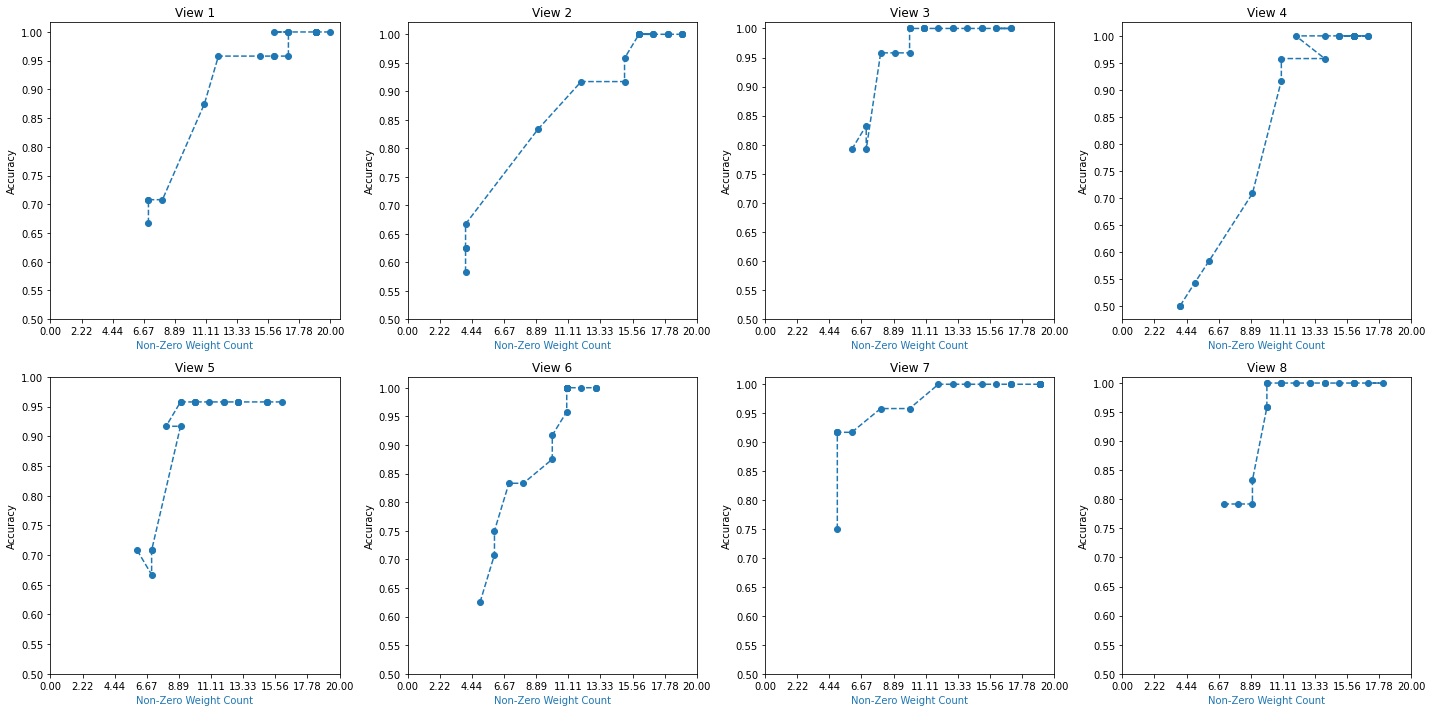

In [90]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #Non-Zero Weight Count Plot
    ax=fig.add_subplot(2, 4, j+1, label="1")

    ax.plot(all_nonzero_weight_cnts[j], all_accuracies[j], marker='o', color="C0", linestyle='dashed')

    ax.set_xlabel("Non-Zero Weight Count", color="C0")
    ax.set_ylabel("Accuracy", color="Black")
    ax.tick_params(axis='x', colors="Black")
    ax.tick_params(axis='y', colors="Black")
    ax.set_yticks([x * 0.05 for x in range(10, 21)])
    ax.set_xticks(np.linspace(0,20,10))

    ax.set_title("View "+str(j+1))

fig.tight_layout()

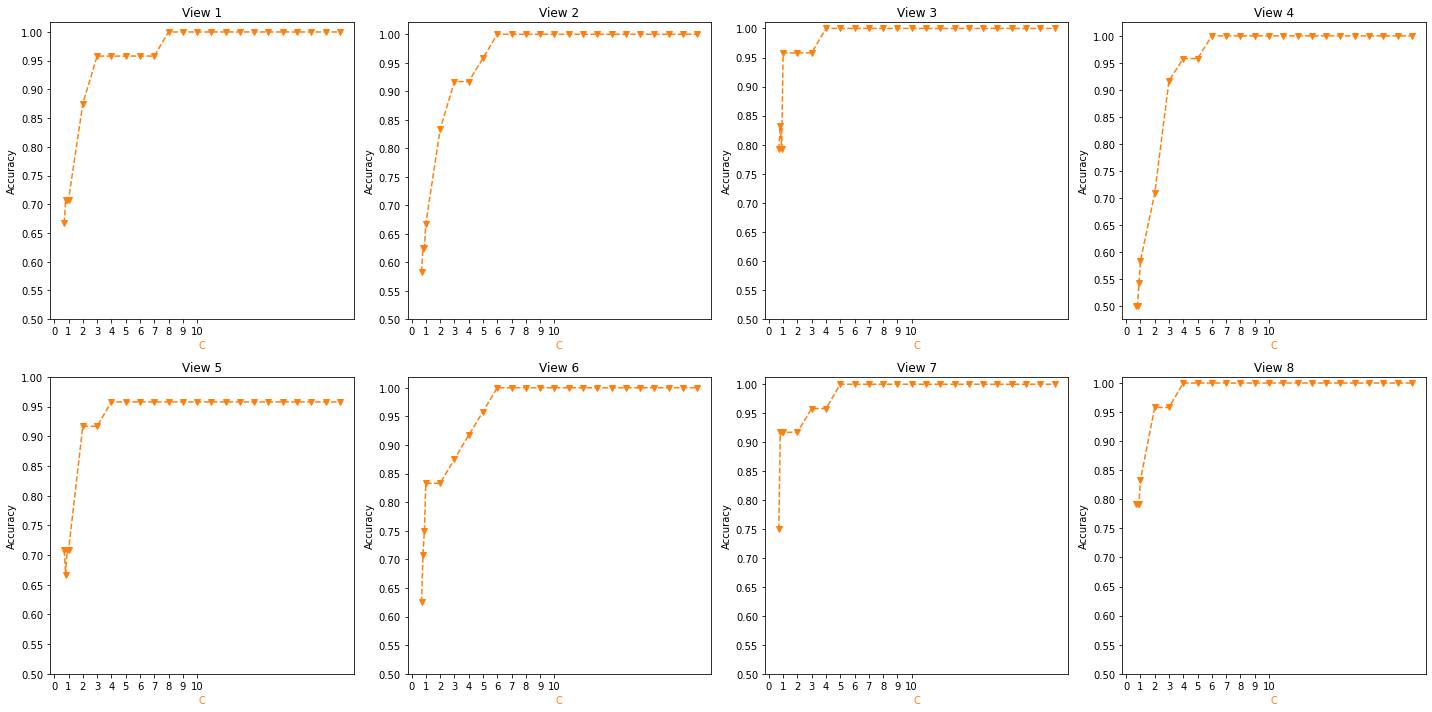

In [91]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #C Value Line
    ax2=fig.add_subplot(2, 4, j+1, label="2")

    ax2.plot(regularizers, all_accuracies[j], marker='v', color="C1", linestyle='dashed')

    # ax2.xaxis.tick_top()
    ax2.set_xlabel('C', color="C1") 
    ax2.set_ylabel("Accuracy", color="Black")
    ax2.tick_params(axis='x', colors="Black")
    ax2.set_yticks([x * 0.05 for x in range(10, 21)])
    ax2.set_xticks(np.linspace(0,10,11))
    # ax2.xaxis.set_label_position('top')

    ax2.set_title("View "+str(j+1))

fig.tight_layout()

In [92]:
###Train only on features from `centers_and_individual_intervals_of_all_intervals`, 
# across different regularizers AND
# on ALL VIEWS

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.7,.8,.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,]

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #####
    
    #Get "Useful Features" from Current view using Center of Intervals
    strip_row_avg = strip_row_avg[centers_and_individual_intervals_of_all_intervals]

    #####

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        tol=5e-3,
                        C=r_c)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
    # display(results)

    #Get index of first 100% Accuracy row
    first_perfect_row_index = results[results.Accuracy==1.0].first_valid_index()

    if first_perfect_row_index:

        #Get row at first_perfect_row_index
        first_perfect_row = pd.DataFrame(results.iloc[first_perfect_row_index])

        #Transpose to row format
        # first_perfect_row = first_perfect_row.transpose()

        #Change index name to match view number
        first_perfect_row = first_perfect_row.rename(columns={first_perfect_row_index:i})

        #Display and Append
        display(first_perfect_row)
        minimized_best_params.append(first_perfect_row)

View 1


,0
Accuracy,1.0
Regularizers,8.0
Unique Non-Zero Weight Count,19.0


View 2


,1
Accuracy,1.0
Regularizers,6.0
Unique Non-Zero Weight Count,16.0


View 3


,2
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,10.0


View 4


,3
Accuracy,1.0
Regularizers,6.0
Unique Non-Zero Weight Count,12.0


View 5
View 6


,5
Accuracy,1.0
Regularizers,6.0
Unique Non-Zero Weight Count,11.0


View 7


,6
Accuracy,1.0
Regularizers,5.0
Unique Non-Zero Weight Count,16.0


View 8


,7
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,11.0


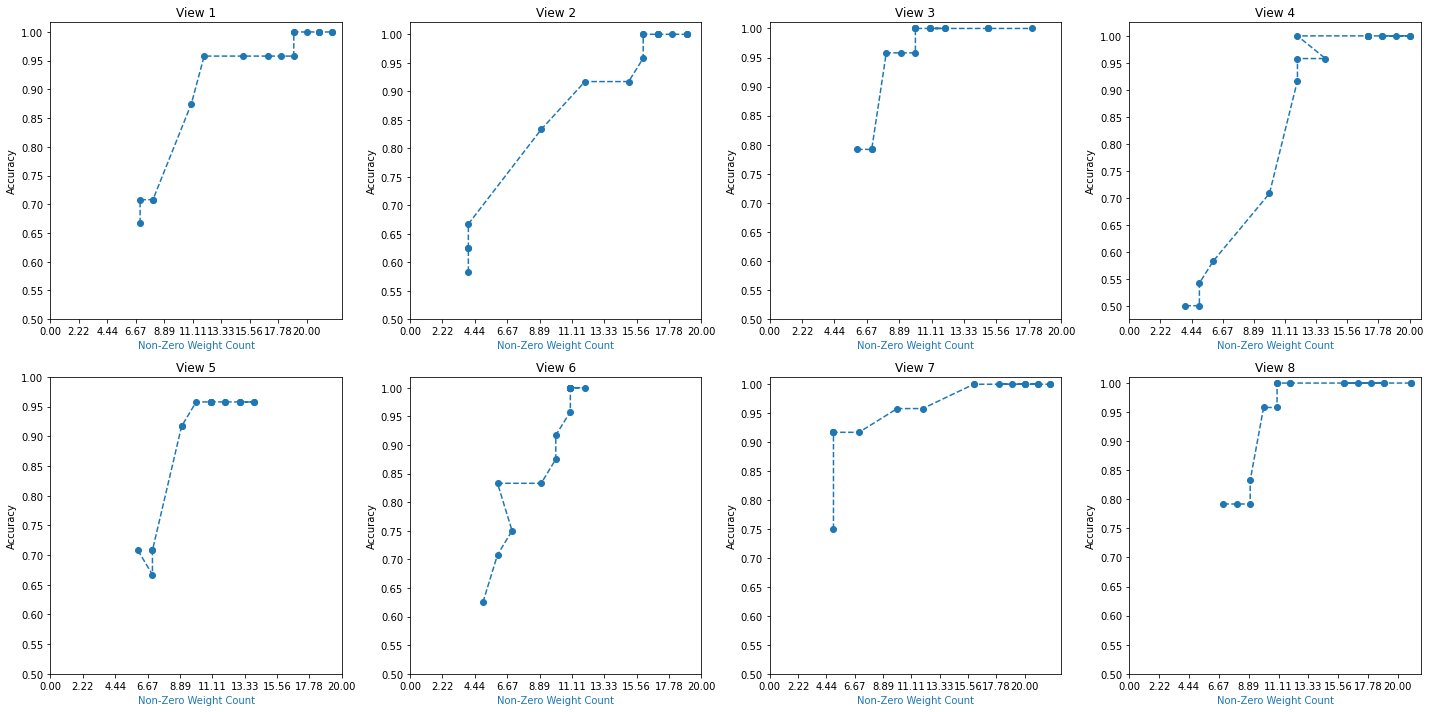

In [93]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #Non-Zero Weight Count Plot
    ax=fig.add_subplot(2, 4, j+1, label="1")

    ax.plot(all_nonzero_weight_cnts[j], all_accuracies[j], marker='o', color="C0", linestyle='dashed')

    ax.set_xlabel("Non-Zero Weight Count", color="C0")
    ax.set_ylabel("Accuracy", color="Black")
    ax.tick_params(axis='x', colors="Black")
    ax.tick_params(axis='y', colors="Black")
    ax.set_yticks([x * 0.05 for x in range(10, 21)])
    ax.set_xticks(np.linspace(0,20,10))

    ax.set_title("View "+str(j+1))

fig.tight_layout()

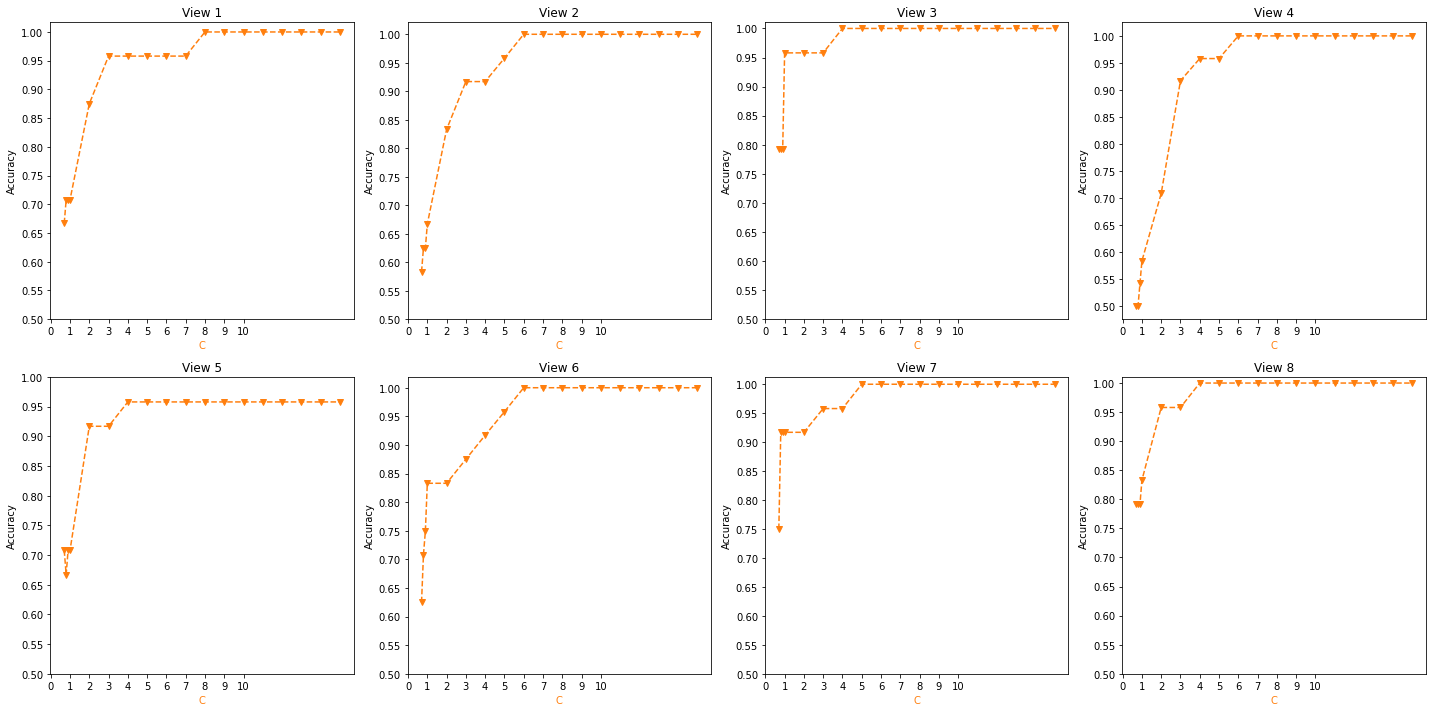

In [94]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #C Value Line
    ax2=fig.add_subplot(2, 4, j+1, label="2")

    ax2.plot(regularizers, all_accuracies[j], marker='v', color="C1", linestyle='dashed')

    # ax2.xaxis.tick_top()
    ax2.set_xlabel('C', color="C1") 
    ax2.set_ylabel("Accuracy", color="Black")
    ax2.tick_params(axis='x', colors="Black")
    ax2.set_yticks([x * 0.05 for x in range(10, 21)])
    ax2.set_xticks(np.linspace(0,10,11))
    # ax2.xaxis.set_label_position('top')

    ax2.set_title("View "+str(j+1))

fig.tight_layout()

### Attempt 5 - Union of Overlapping Intervals where Intervals are Looser (10 values apart)

In [95]:
#Get intervals for sorted list of combined important features
all_possible_intervals = list(interval_extract_loose(combined_important_features,10))
# print(len(all_possible_intervals))
# print(all_possible_intervals)

In [96]:
#Print length of each interval
lengths_of_intervals = []
for item in all_possible_intervals:
    if len(item) == 2:
        lengths_of_intervals.append(item[1]-item[0])
print(lengths_of_intervals)

[54, 60, 11, 9, 32, 5, 22, 77, 40, 24, 12, 50, 37, 4, 47, 38, 14, 11, 38]


In [97]:
#Create array of
    # 1) All individual Values from 'all_possible_intervals' 
    # AND Center of any actual intervals from above array
    # 2) Only Center values from real intervals

centers_and_individual_intervals_of_all_intervals = []
only_centers_of_all_intervals = []

for item in all_possible_intervals:
    if len(item) == 2:
        center = int(round( (item[0]+item[1]) / 2, 0))
        only_centers_of_all_intervals.append(center)
        centers_and_individual_intervals_of_all_intervals.append(center)
    else:
        centers_and_individual_intervals_of_all_intervals.append(item[0])

print(len(centers_and_individual_intervals_of_all_intervals))
print(len(only_centers_of_all_intervals))

19
19


In [98]:
# Append final column index to feature arrays which is 
# Target Column from original feature vector

#Get count of Original Features
original_number_of_features = len(multiview_strip_row_avg_list[0][0])

#Append count - 1 to end of new features
centers_and_individual_intervals_of_all_intervals.append(original_number_of_features-1)
only_centers_of_all_intervals.append(original_number_of_features-1)

In [99]:
###Train only on features from `only_centers_of_all_intervals`, 
# across different regularizers AND
# on ALL VIEWS

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.7,.8,.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

only_centers_results = []

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #####
    
    #Get "Useful Features" from Current view using Center of Intervals
    strip_row_avg = strip_row_avg[only_centers_of_all_intervals]

    #####

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        tol=2e-3,
                        C=r_c)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
    # display(results)

    #Get index of first 100% Accuracy row
    first_perfect_row_index = results[results.Accuracy==1.0].first_valid_index()
    if first_perfect_row_index:

        #Get row at first_perfect_row_index
        first_perfect_row = pd.DataFrame(results.iloc[first_perfect_row_index])

        #Transpose to row format
        # first_perfect_row = first_perfect_row.transpose()

        #Change index name to match view number
        first_perfect_row = first_perfect_row.rename(columns={first_perfect_row_index:i})

        #Display and Append
        display(first_perfect_row)
        minimized_best_params.append(first_perfect_row)
        
    else:
        #Get index of Max Accuracy Row
        max_acc_row_index = results.idxmax()[0]

        #Get max Accuracy row at above index
        max_acc_row = pd.DataFrame(results.iloc[max_acc_row_index])

        #Change index name to match view number
        max_acc_row = max_acc_row.rename(columns={max_acc_row_index:i})

        #Display and Append
        display(max_acc_row)
        minimized_best_params.append(max_acc_row)

only_centers_results.append(minimized_best_params)

View 1


,0
Accuracy,1.0
Regularizers,10.0
Unique Non-Zero Weight Count,12.0


View 2


,1
Accuracy,1.0
Regularizers,12.0
Unique Non-Zero Weight Count,14.0


View 3


,2
Accuracy,1.0
Regularizers,6.0
Unique Non-Zero Weight Count,9.0


View 4


,3
Accuracy,1.0
Regularizers,7.0
Unique Non-Zero Weight Count,12.0


View 5


,4
Accuracy,0.917
Regularizers,2.000
Unique Non-Zero Weight Count,5.000


View 6


,5
Accuracy,1.0
Regularizers,8.0
Unique Non-Zero Weight Count,11.0


View 7


,6
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,10.0


View 8


,7
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,10.0


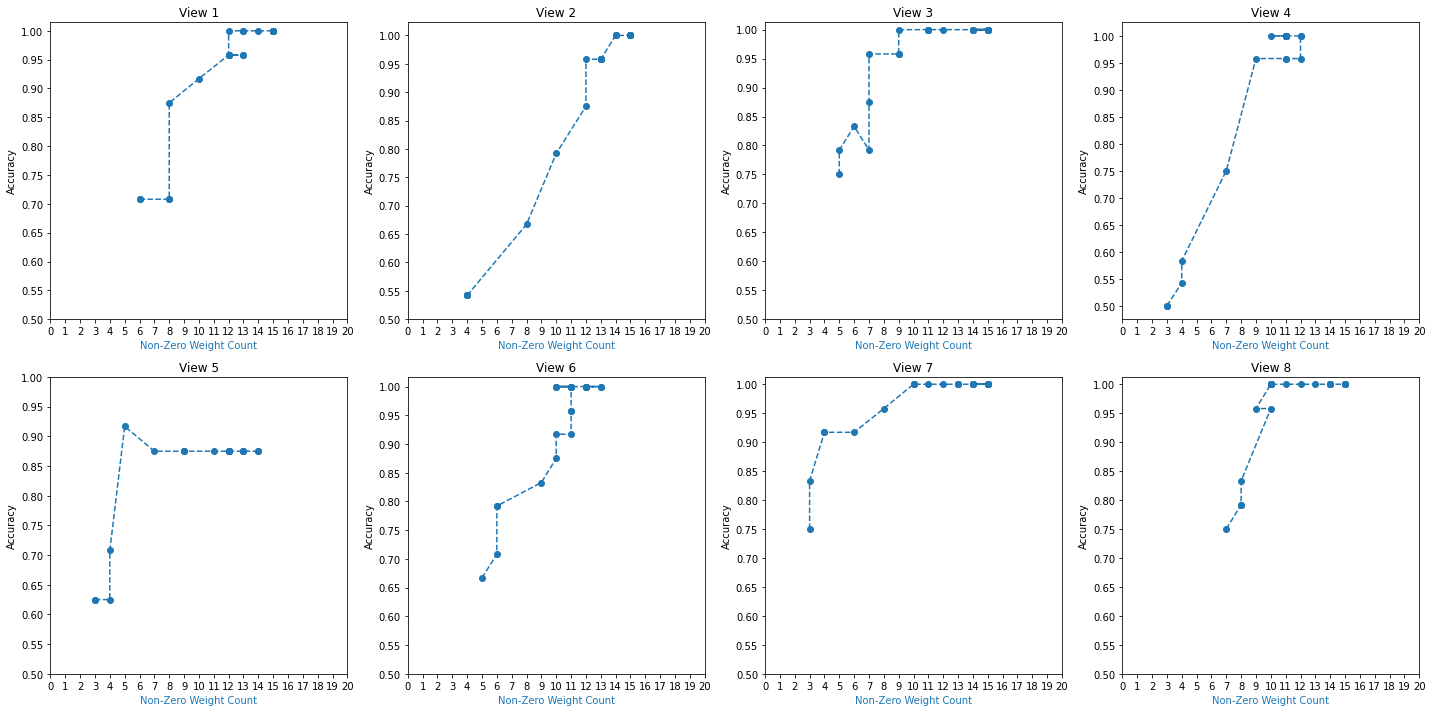

In [100]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #Non-Zero Weight Count Plot
    ax=fig.add_subplot(2, 4, j+1, label="1")

    ax.plot(all_nonzero_weight_cnts[j], all_accuracies[j], marker='o', color="C0", linestyle='dashed')

    ax.set_xlabel("Non-Zero Weight Count", color="C0")
    ax.set_ylabel("Accuracy", color="Black")
    ax.tick_params(axis='x', colors="Black")
    ax.tick_params(axis='y', colors="Black")
    ax.set_yticks([x * 0.05 for x in range(10, 21)])
    ax.set_xticks(np.linspace(0,20,21))

    ax.set_title("View "+str(j+1))

fig.tight_layout()

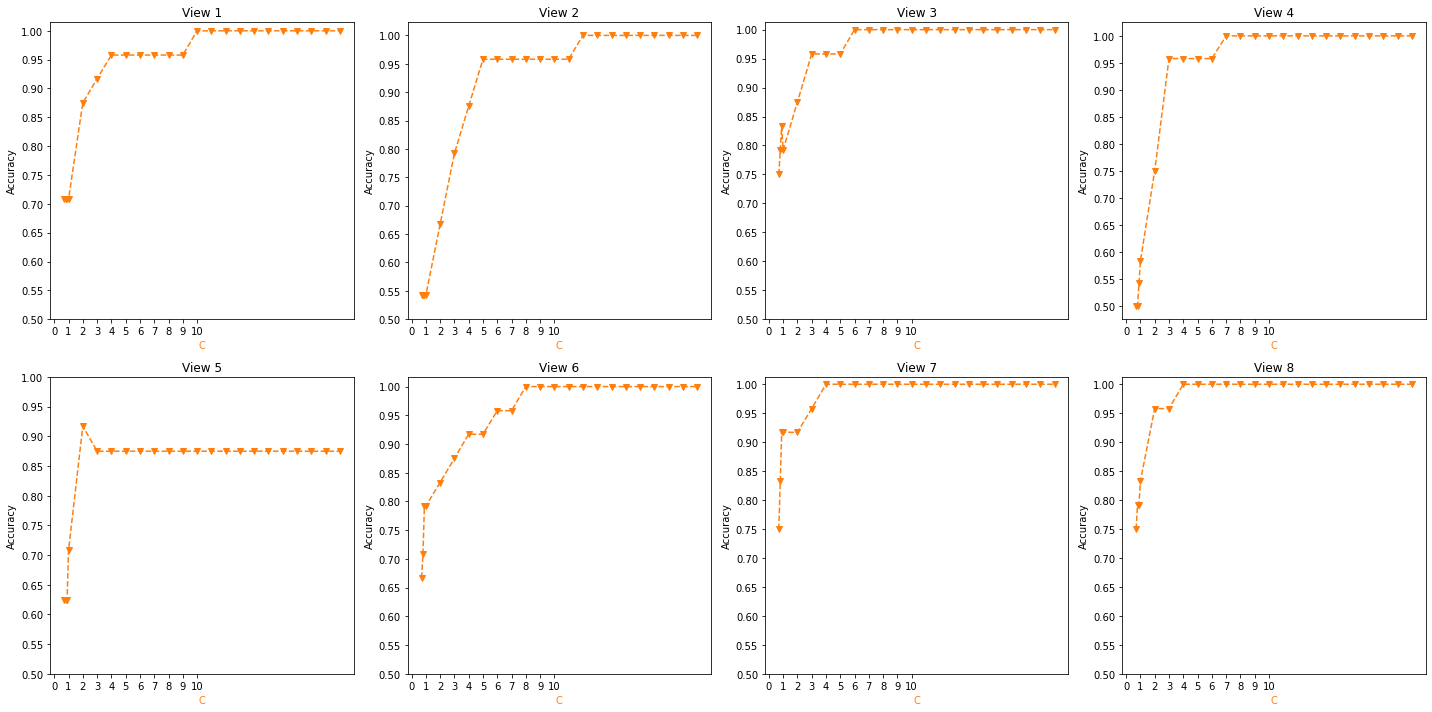

In [101]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #C Value Line
    ax2=fig.add_subplot(2, 4, j+1, label="2")

    ax2.plot(regularizers, all_accuracies[j], marker='v', color="C1", linestyle='dashed')

    # ax2.xaxis.tick_top()
    ax2.set_xlabel('C', color="C1") 
    ax2.set_ylabel("Accuracy", color="Black")
    ax2.tick_params(axis='x', colors="Black")
    ax2.set_yticks([x * 0.05 for x in range(10, 21)])
    ax2.set_xticks(np.linspace(0,10,11))
    # ax2.xaxis.set_label_position('top')

    ax2.set_title("View "+str(j+1))

fig.tight_layout()

In [102]:
###Train only on features from `centers_and_individual_intervals_of_all_intervals`, 
# across different regularizers AND
# on ALL VIEWS

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.7,.8,.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,]

centers_and_individual_results = []

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #####
    
    #Get "Useful Features" from Current view using Center of Intervals
    strip_row_avg = strip_row_avg[centers_and_individual_intervals_of_all_intervals]

    #####

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        tol=5e-3,
                        C=r_c)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
    # display(results)

    #Get index of first 100% Accuracy row
    first_perfect_row_index = results[results.Accuracy==1.0].first_valid_index()

    if first_perfect_row_index:

        #Get row at first_perfect_row_index
        first_perfect_row = pd.DataFrame(results.iloc[first_perfect_row_index])

        #Transpose to row format
        # first_perfect_row = first_perfect_row.transpose()

        #Change index name to match view number
        first_perfect_row = first_perfect_row.rename(columns={first_perfect_row_index:i})

        #Display and Append
        display(first_perfect_row)
        minimized_best_params.append(first_perfect_row)
    else:
        #Get index of Max Accuracy Row
        max_acc_row_index = results.idxmax()[0]

        #Get max Accuracy row at above index
        max_acc_row = pd.DataFrame(results.iloc[max_acc_row_index])

        #Change index name to match view number
        max_acc_row = max_acc_row.rename(columns={max_acc_row_index:i})

        #Display and Append
        display(max_acc_row)
        minimized_best_params.append(max_acc_row)


centers_and_individual_results.append(minimized_best_params)

View 1


,0
Accuracy,1.0
Regularizers,10.0
Unique Non-Zero Weight Count,14.0


View 2


,1
Accuracy,1.0
Regularizers,12.0
Unique Non-Zero Weight Count,14.0


View 3


,2
Accuracy,1.0
Regularizers,6.0
Unique Non-Zero Weight Count,9.0


View 4


,3
Accuracy,1.0
Regularizers,7.0
Unique Non-Zero Weight Count,12.0


View 5


,4
Accuracy,0.917
Regularizers,2.000
Unique Non-Zero Weight Count,6.000


View 6


,5
Accuracy,1.0
Regularizers,8.0
Unique Non-Zero Weight Count,11.0


View 7


,6
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,10.0


View 8


,7
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,11.0


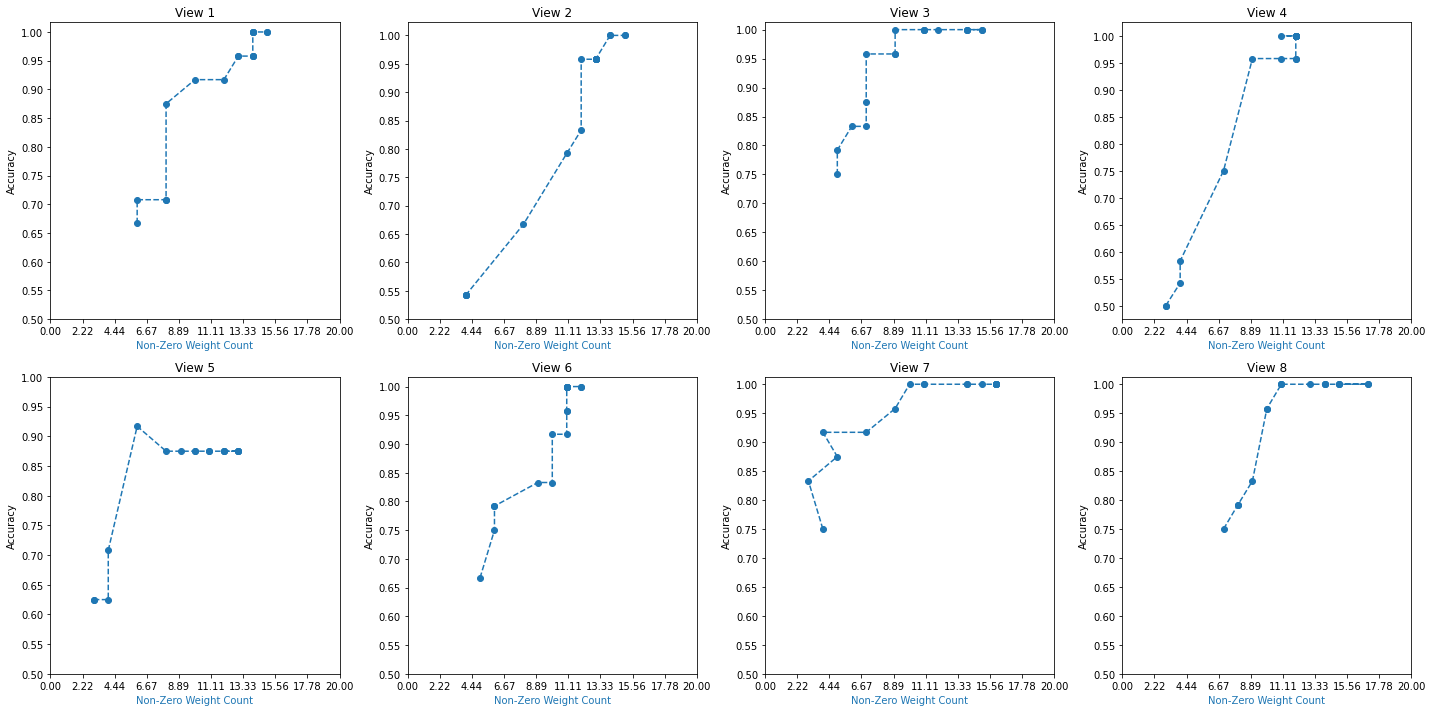

In [103]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #Non-Zero Weight Count Plot
    ax=fig.add_subplot(2, 4, j+1, label="1")

    ax.plot(all_nonzero_weight_cnts[j], all_accuracies[j], marker='o', color="C0", linestyle='dashed')

    ax.set_xlabel("Non-Zero Weight Count", color="C0")
    ax.set_ylabel("Accuracy", color="Black")
    ax.tick_params(axis='x', colors="Black")
    ax.tick_params(axis='y', colors="Black")
    ax.set_yticks([x * 0.05 for x in range(10, 21)])
    ax.set_xticks(np.linspace(0,20,10))

    ax.set_title("View "+str(j+1))

fig.tight_layout()

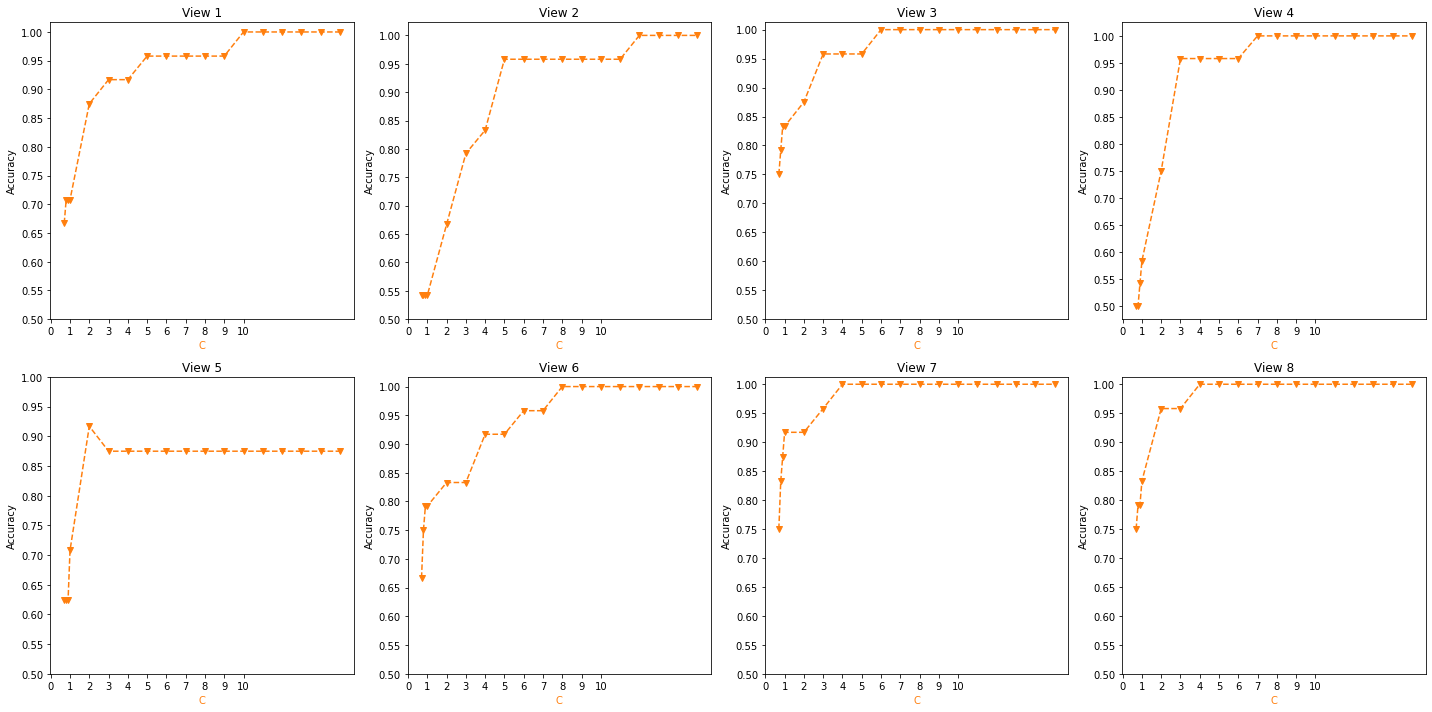

In [104]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #C Value Line
    ax2=fig.add_subplot(2, 4, j+1, label="2")

    ax2.plot(regularizers, all_accuracies[j], marker='v', color="C1", linestyle='dashed')

    # ax2.xaxis.tick_top()
    ax2.set_xlabel('C', color="C1") 
    ax2.set_ylabel("Accuracy", color="Black")
    ax2.tick_params(axis='x', colors="Black")
    ax2.set_yticks([x * 0.05 for x in range(10, 21)])
    ax2.set_xticks(np.linspace(0,10,11))
    # ax2.xaxis.set_label_position('top')

    ax2.set_title("View "+str(j+1))

fig.tight_layout()

##### Comparing Results of Centers Only vs Centers and Individual Intervals

In [105]:
#Transform only_centers_results to proper format
only_centers_results = np.array(only_centers_results).squeeze()
only_centers_results = pd.DataFrame(only_centers_results)
only_centers_results = only_centers_results.rename(columns={0:"Accuracy",1:"Regularizer",2:"Number of Features"})
display(only_centers_results)

,Accuracy,Regularizer,Number of Features
0,1.000,10.0,12.0
1,1.000,12.0,14.0
2,1.000,6.0,9.0
3,1.000,7.0,12.0
4,0.917,2.0,5.0
5,1.000,8.0,11.0
6,1.000,4.0,10.0
7,1.000,4.0,10.0


In [106]:
#Transform centers_and_individual_results to proper format
centers_and_individual_results = np.array(centers_and_individual_results).squeeze()
centers_and_individual_results = pd.DataFrame(centers_and_individual_results)
centers_and_individual_results = centers_and_individual_results.rename(columns={0:"Accuracy",1:"Regularizer",2:"Number of Features"})
display(centers_and_individual_results)

,Accuracy,Regularizer,Number of Features
0,1.000,10.0,14.0
1,1.000,12.0,14.0
2,1.000,6.0,9.0
3,1.000,7.0,12.0
4,0.917,2.0,6.0
5,1.000,8.0,11.0
6,1.000,4.0,10.0
7,1.000,4.0,11.0


In [107]:
min_params_comparison = pd.concat([only_centers_results,centers_and_individual_results],axis=1)

In [108]:
display(min_params_comparison)

,Accuracy,Regularizer,Number of Features,Accuracy,Regularizer,Number of Features
0,1.000,10.0,12.0,1.000,10.0,14.0
1,1.000,12.0,14.0,1.000,12.0,14.0
2,1.000,6.0,9.0,1.000,6.0,9.0
3,1.000,7.0,12.0,1.000,7.0,12.0
4,0.917,2.0,5.0,0.917,2.0,6.0
5,1.000,8.0,11.0,1.000,8.0,11.0
6,1.000,4.0,10.0,1.000,4.0,10.0
7,1.000,4.0,10.0,1.000,4.0,11.0


##### Conclusion: `Only Centers` results in nominal (1 or 2) fewer features used and maintains the same accuracy and Regularizer for each view

### Draw Lines at Centers of Intervals (for relaxation value of 10)

In [109]:
#Get intervals for sorted list of combined important features
all_possible_intervals = list(interval_extract_loose(combined_important_features,10))
# print(len(all_possible_intervals))
# print(all_possible_intervals)

In [110]:
#Print length of each interval
lengths_of_intervals = []
for item in all_possible_intervals:
    if len(item) == 2:
        lengths_of_intervals.append(item[1]-item[0])
print(lengths_of_intervals)

[54, 60, 11, 9, 32, 5, 22, 77, 40, 24, 12, 50, 37, 4, 47, 38, 14, 11, 38]


In [111]:
#Create array of
    # 1) All individual Values from 'all_possible_intervals' 
    # AND Center of any actual intervals from above array
    # 2) Only Center values from real intervals

centers_and_individual_intervals_of_all_intervals = []
only_centers_of_all_intervals = []

for item in all_possible_intervals:
    if len(item) == 2:
        center = int(round( (item[0]+item[1]) / 2, 0))
        only_centers_of_all_intervals.append(center)
        centers_and_individual_intervals_of_all_intervals.append(center)
    else:
        centers_and_individual_intervals_of_all_intervals.append(item[0])

print(len(centers_and_individual_intervals_of_all_intervals))
print(len(only_centers_of_all_intervals))

19
19


In [112]:
print(only_centers_of_all_intervals)

[27, 102, 150, 212, 248, 278, 390, 476, 554, 597, 633, 676, 744, 775, 826, 883, 941, 966, 1009]


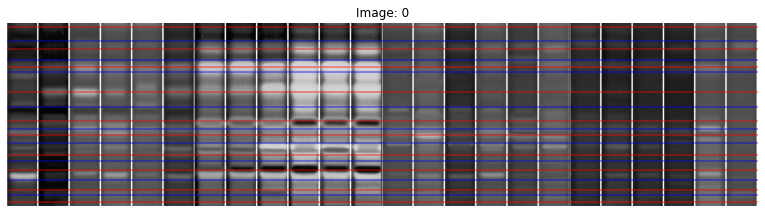

In [113]:
fig = plt.figure(figsize=(30, 15))
for i, img in enumerate(cropped_img_list):
    sub = fig.add_subplot(4, 2, i + 1)
    sub.axis('off')
    sub.imshow(img,cmap='gray')
    for m, val in enumerate(only_centers_of_all_intervals):
        if m % 2 == 0:
            c = 'red'
        else:
            c = 'blue'
        sub.axhline(val,color=c,alpha=.5)
    sub.set_title('Image: '+str(i))
    break
plt.tight_layout
fig.subplots_adjust(wspace=.02, hspace=.15)

### Draw Lines at Features used for 100% Classification of View 3
    (Case with Minimum number of Features)

In [114]:
#Get intervals for sorted list of combined important features
all_possible_intervals = list(interval_extract_loose(combined_important_features,10))
# print(len(all_possible_intervals))
# print(all_possible_intervals)

In [115]:
#Print length of each interval
lengths_of_intervals = []
for item in all_possible_intervals:
    if len(item) == 2:
        lengths_of_intervals.append(item[1]-item[0])
print(lengths_of_intervals)

[54, 60, 11, 9, 32, 5, 22, 77, 40, 24, 12, 50, 37, 4, 47, 38, 14, 11, 38]


In [116]:
#Create array of
    # 1) All individual Values from 'all_possible_intervals' 
    # AND Center of any actual intervals from above array
    # 2) Only Center values from real intervals

centers_and_individual_intervals_of_all_intervals = []
only_centers_of_all_intervals = []

for item in all_possible_intervals:
    if len(item) == 2:
        center = int(round( (item[0]+item[1]) / 2, 0))
        only_centers_of_all_intervals.append(center)
        centers_and_individual_intervals_of_all_intervals.append(center)
    else:
        centers_and_individual_intervals_of_all_intervals.append(item[0])

print(len(centers_and_individual_intervals_of_all_intervals))
print(len(only_centers_of_all_intervals))

19
19


In [117]:
# Append final column index to feature arrays which is 
# Target Column from original feature vector

#Get count of Original Features
original_number_of_features = len(multiview_strip_row_avg_list[0][0])

#Append count - 1 to end of new features
centers_and_individual_intervals_of_all_intervals.append(original_number_of_features-1)
only_centers_of_all_intervals.append(original_number_of_features-1)

In [123]:
###Train only on features from `centers_and_individual_intervals_of_all_intervals`, 
# across different regularizers on View 3

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[6]

#SET WHICH VIEW TO USE HERE
strip_row_avg = multiview_strip_row_avg_list[2]

accuracy = []
nonzero_weight_cnt = []

#Convert to Dataframe
strip_row_avg = pd.DataFrame(strip_row_avg)

#####

#Get "Useful Features" from Current view using Center of Intervals
strip_row_avg = strip_row_avg[centers_and_individual_intervals_of_all_intervals]

#####

#Get Features
df_feat = strip_row_avg.iloc[:,:-2]

#Get Targets & Format to 1D vector
df_target = strip_row_avg.iloc[:,-1:]
df_target = df_target.values.ravel()

#Create Model
model = LinearSVC()

#Set Model Parameters
for r_c in regularizers:
    #l1, squared_hinge, dual = False
    model.set_params(random_state=101,
                    verbose=0,
                    max_iter=4500,
                    penalty='l1',
                    loss='squared_hinge',
                    dual=False,
                    tol=5e-3,
                    C=r_c)

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
    accuracy.append(round(model.score(df_feat,df_target),3))

    #Append Count of Number of Non-Zero Weights
    nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
    # print(np.count_nonzero(model.coef_))

all_accuracies.append(accuracy)
all_nonzero_weight_cnts.append(nonzero_weight_cnt)

#####
#Get Table of non-zero coefs in model's coef
#   Row 1 holds the row index values in the full coef table
#   Row 2 holds the column index values in the full coef table
model_coefs_nonzero = pd.DataFrame(np.nonzero(model.coef_.copy()))

#Get Array of Unique Columns with at least 1 non-zero value
nonzero_cols = np.unique(model_coefs_nonzero.iloc[1])

print('View '+str(i+1))
results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
display(results)

View 1


,Accuracy,Regularizers,Unique Non-Zero Weight Count
0,1.0,6,9


In [124]:
#Get Indexes of Columns with at least 1 Non-Zero Value
# (need to change to np.array to do easy index splicing)
nonzero_cols = np.array(nonzero_cols)
centers_and_individual_intervals_of_all_intervals = np.array(centers_and_individual_intervals_of_all_intervals)
most_useful_features = centers_and_individual_intervals_of_all_intervals[nonzero_cols]
print(len(most_useful_features))

9


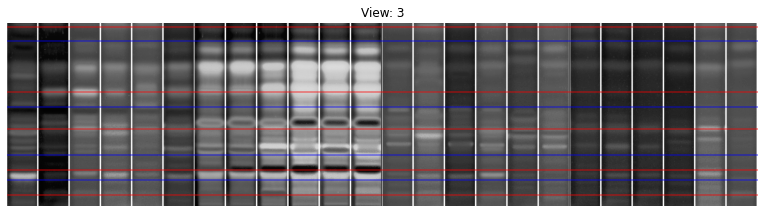

In [125]:
fig = plt.figure(figsize=(30, 15))
for i, img in enumerate(cropped_img_list):
    sub = fig.add_subplot(4, 2, i + 1)
    sub.axis('off')
    sub.imshow(img,cmap='gray')
    for m, val in enumerate(most_useful_features):
        if m % 2 == 0:
            c = 'red'
        else:
            c = 'blue'
        sub.axhline(val,color=c,alpha=.5)
    sub.set_title('View: 3')
    break
plt.tight_layout
fig.subplots_adjust(wspace=.02, hspace=.15)

# Conclusion
    Using a relaxation of 5 increments apart, we can get 100% across all Views using a number of features in the teens

    Using a relaxation of 10 increments apart, we can get 100% across all Views using a number of features ~= 10

### Train Using Minimal Number of Features as determined by Intervals w/ Relaxation of 10 to determine if we can trim down features further

In [75]:
#Get intervals for sorted list of combined important features
all_possible_intervals = list(interval_extract_loose(combined_important_features,10))
# print(len(all_possible_intervals))
# print(all_possible_intervals)

In [76]:
#Print length of each interval
lengths_of_intervals = []
for item in all_possible_intervals:
    if len(item) == 2:
        lengths_of_intervals.append(item[1]-item[0])
print(lengths_of_intervals)

[54, 60, 11, 9, 32, 5, 22, 77, 40, 24, 12, 50, 37, 4, 47, 38, 14, 11, 38]


In [77]:
#Create array of
    # 1) All individual Values from 'all_possible_intervals' 
    # AND Center of any actual intervals from above array
    # 2) Only Center values from real intervals

centers_and_individual_intervals_of_all_intervals = []
only_centers_of_all_intervals = []

for item in all_possible_intervals:
    if len(item) == 2:
        center = int(round( (item[0]+item[1]) / 2, 0))
        only_centers_of_all_intervals.append(center)
        centers_and_individual_intervals_of_all_intervals.append(center)
    else:
        centers_and_individual_intervals_of_all_intervals.append(item[0])

print(len(centers_and_individual_intervals_of_all_intervals))
print(len(only_centers_of_all_intervals))

19
19


In [78]:
# Append final column index to feature arrays which is 
# Target Column from original feature vector

#Get count of Original Features
original_number_of_features = len(multiview_strip_row_avg_list[0][0])

#Append count - 1 to end of new features
centers_and_individual_intervals_of_all_intervals.append(original_number_of_features-1)
only_centers_of_all_intervals.append(original_number_of_features-1)

In [87]:
###Train only on features from `centers_and_individual_intervals_of_all_intervals`, 
# across different regularizers AND
# on ALL VIEWS

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.7,.8,.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,]

#NEW ARRAY: important features from e/ View When Training on 19 most important features
#We expect Each View have 9-15 important features, and we will take the distinct onces
important_features_by_view_minimized = []

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #####
    
    #Get "Useful Features" from Current view using Center of Intervals
    strip_row_avg = strip_row_avg[centers_and_individual_intervals_of_all_intervals]

    #####

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        tol=5e-3,
                        C=r_c)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
    # display(results)

    #Get index of first 100% Accuracy row
    first_perfect_row_index = results[results.Accuracy==1.0].first_valid_index()

    #####
    #Get Table of non-zero coefs in model's coef
    #   Row 1 holds the row index values in the full coef table
    #   Row 2 holds the column index values in the full coef table
    model_coefs_nonzero = pd.DataFrame(np.nonzero(model.coef_.copy()))

    #Get Array of Unique Columns with at least 1 non-zero value
    nonzero_cols = np.unique(model_coefs_nonzero.iloc[1])

    important_features_by_view_minimized.append(list(nonzero_cols))

View 1
View 2
View 3
View 4
View 5
View 6
View 7
View 8


In [88]:
print(important_features_by_view_minimized)

[[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 13, 14, 15, 16, 17], [0, 1, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], [0, 1, 2, 3, 5, 6, 7, 9, 12, 13, 14, 15, 16, 17], [0, 1, 2, 3, 6, 7, 9, 12, 13, 14, 16, 17], [0, 1, 2, 3, 5, 6, 7, 8, 9, 12, 13, 16], [0, 1, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17], [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17], [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]]


In [89]:
#Get Original column indexes using indexes from important_features_by_view_minimized

#Ensure that we can extract an array of values with another array of indices
#First, convert array w/ references to original column indices to np.arry
centers_and_individual_intervals_of_all_intervals = np.array(centers_and_individual_intervals_of_all_intervals)
#Second, convert array w/ indices of above array to np.arry
important_features_by_view_minimized = np.array(important_features_by_view_minimized)

#Get indices of original columns in from every view and append to one array
combined_important_features_by_view_minimized = np.concatenate(important_features_by_view_minimized)

#Make sure we only get distinct indices of columns
combined_important_features_by_view_minimized = np.unique(combined_important_features_by_view_minimized)

#Get Original Feature Column Indices
combined_important_features_by_view_minimized = centers_and_individual_intervals_of_all_intervals[combined_important_features_by_view_minimized]

<ipython-input-89-ce005e85edba>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  important_features_by_view_minimized = np.array(important_features_by_view_minimized)


In [90]:
print(combined_important_features_by_view_minimized)
print(len(combined_important_features_by_view_minimized))

[ 27 102 150 212 248 278 390 476 554 597 633 676 744 775 826 883 941 966]
18


In [91]:
# Append final column index to feature arrays which is 
# Target Column from original feature vector

#Get count of Original Features
original_number_of_features = len(multiview_strip_row_avg_list[0][0])

#Append count - 1 to end of new features
combined_important_features_by_view_minimized = combined_important_features_by_view_minimized.tolist()
combined_important_features_by_view_minimized.append(original_number_of_features-1)

In [92]:
print(combined_important_features_by_view_minimized)
print(len(combined_important_features_by_view_minimized))

[27, 102, 150, 212, 248, 278, 390, 476, 554, 597, 633, 676, 744, 775, 826, 883, 941, 966, 1030]
19


##### Train on above `combined_important_features_by_view_minimized`

In [93]:
###Train only on features from `only_centers_of_all_intervals`, 
# across different regularizers AND
# on ALL VIEWS

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.7,.8,.9,1,2,3,4,5,6,7,8,9,10,11,12,13]

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #####
    
    #Get "Useful Features" from Current view using Center of Intervals
    strip_row_avg = strip_row_avg[combined_important_features_by_view_minimized]

    #####

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        tol=2e-3,
                        C=r_c)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
    # display(results)

    #Get index of first 100% Accuracy row
    first_perfect_row_index = results[results.Accuracy==1.0].first_valid_index()

    if first_perfect_row_index:
        #Get row at first_perfect_row_index
        first_perfect_row = pd.DataFrame(results.iloc[first_perfect_row_index])

        #Change index name to match view number
        first_perfect_row = first_perfect_row.rename(columns={first_perfect_row_index:i})

        #Display and Append
        display(first_perfect_row)
        minimized_best_params.append(first_perfect_row)

View 1


,0
Accuracy,1.0
Regularizers,11.0
Unique Non-Zero Weight Count,11.0


View 2


,1
Accuracy,1.0
Regularizers,12.0
Unique Non-Zero Weight Count,14.0


View 3


,2
Accuracy,1.0
Regularizers,8.0
Unique Non-Zero Weight Count,10.0


View 4


,3
Accuracy,1.0
Regularizers,7.0
Unique Non-Zero Weight Count,12.0


View 5
View 6


,5
Accuracy,1.0
Regularizers,8.0
Unique Non-Zero Weight Count,10.0


View 7


,6
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,10.0


View 8


,7
Accuracy,1.0
Regularizers,4.0
Unique Non-Zero Weight Count,9.0


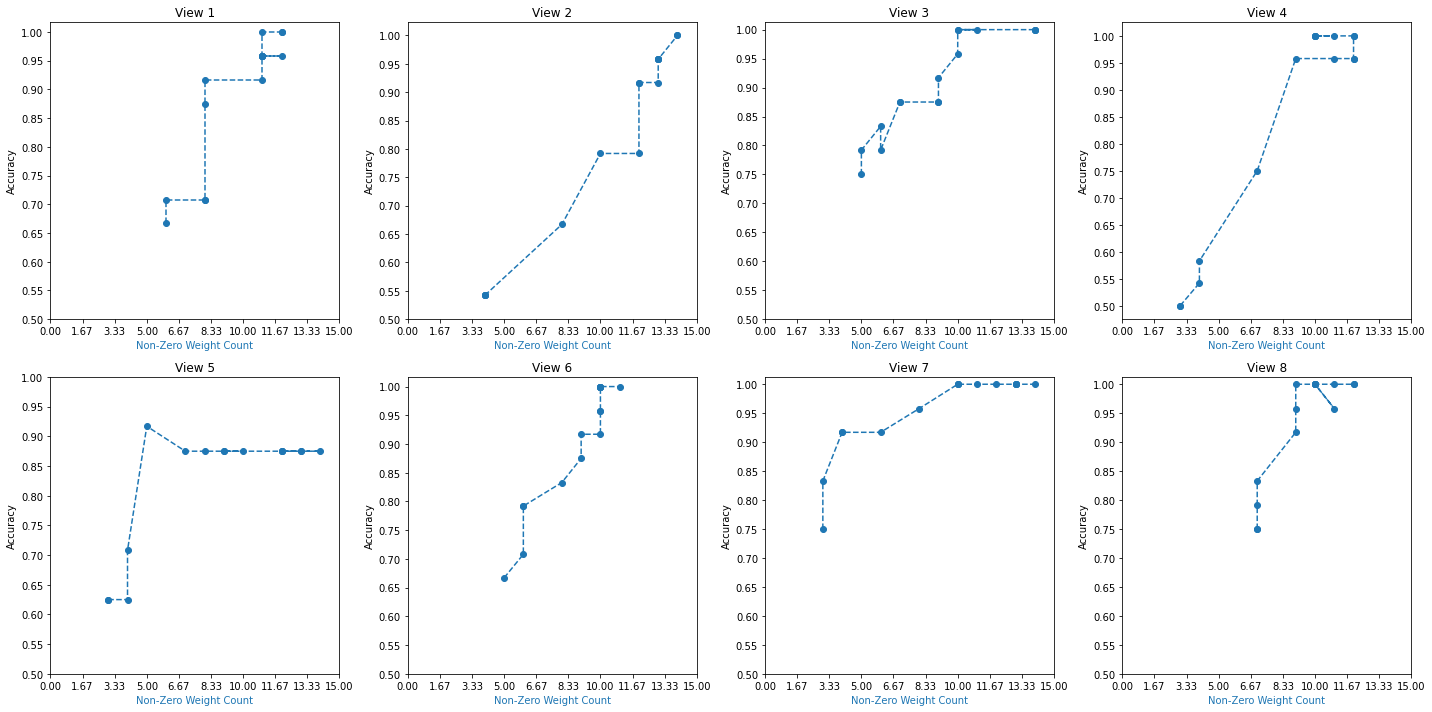

In [94]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #Non-Zero Weight Count Plot
    ax=fig.add_subplot(2, 4, j+1, label="1")

    ax.plot(all_nonzero_weight_cnts[j], all_accuracies[j], marker='o', color="C0", linestyle='dashed')

    ax.set_xlabel("Non-Zero Weight Count", color="C0")
    ax.set_ylabel("Accuracy", color="Black")
    ax.tick_params(axis='x', colors="Black")
    ax.tick_params(axis='y', colors="Black")
    ax.set_yticks([x * 0.05 for x in range(10, 21)])
    ax.set_xticks(np.linspace(0,15,10))

    ax.set_title("View "+str(j+1))

fig.tight_layout()

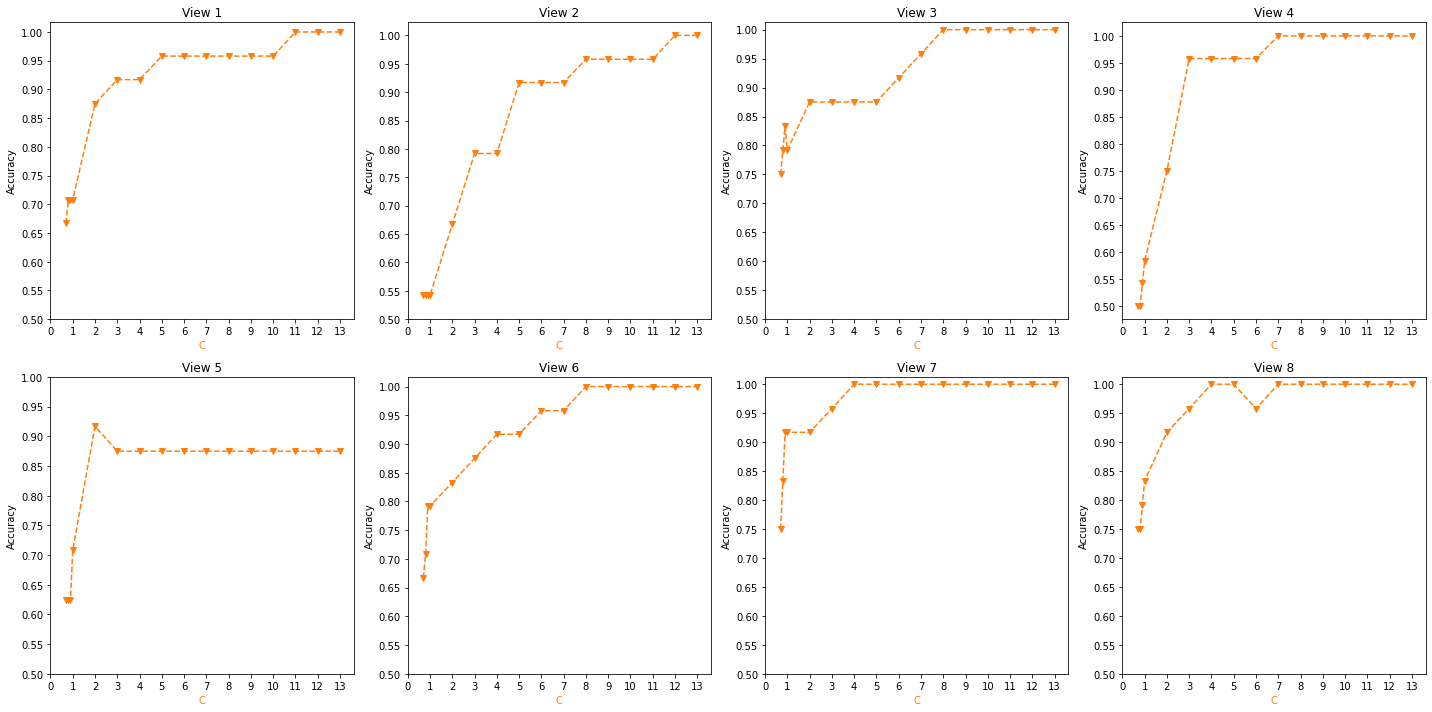

In [95]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #C Value Line
    ax2=fig.add_subplot(2, 4, j+1, label="2")

    ax2.plot(regularizers, all_accuracies[j], marker='v', color="C1", linestyle='dashed')

    # ax2.xaxis.tick_top()
    ax2.set_xlabel('C', color="C1") 
    ax2.set_ylabel("Accuracy", color="Black")
    ax2.tick_params(axis='x', colors="Black")
    ax2.set_yticks([x * 0.05 for x in range(10, 21)])
    ax2.set_xticks(np.linspace(0,13,14))
    # ax2.xaxis.set_label_position('top')

    ax2.set_title("View "+str(j+1))

fig.tight_layout()